In [221]:
import glob
import os
from pickle import Pickler, Unpickler
import matplotlib.pyplot as plt 
import numpy as np
from peyl import polymat, JonesCellRep, BraidGroup, GNF, Permutation
from peyl.braid import PermTable

import seaborn as sns
import pandas as pd

In [220]:
iterationTrainExamples = []
action_lists_projlens = []
epochs = []
folder = "./temp"
# folder = "/tigress/qanguyen/alpha-zero-general/temp"
for epoch in range(0,14,1):
    fs = glob.glob(os.path.join(folder, f"testcheckpoint_epoch_{epoch}_mod_p_3" + "*.examples"))
    for filename in fs:
        with open(filename, "rb") as f:
            iterationTrainExamples.extend(Unpickler(f).load())

    fs = glob.glob(os.path.join(folder, f"iteration_{epoch}" + "*.actions_projlens"))
    for filename in fs:
        with open(filename, "rb") as f:
            action_lists_projlens.append(Unpickler(f).load())
            epochs.extend([epoch] * 100)

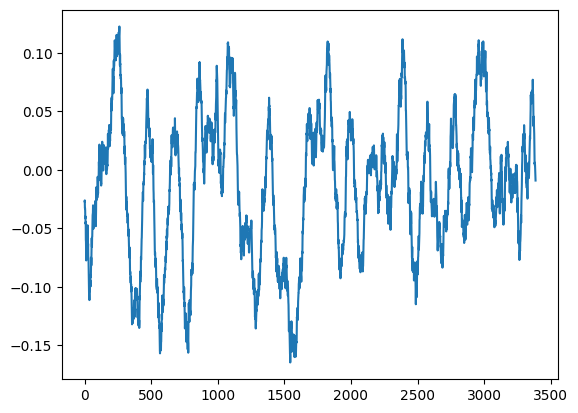

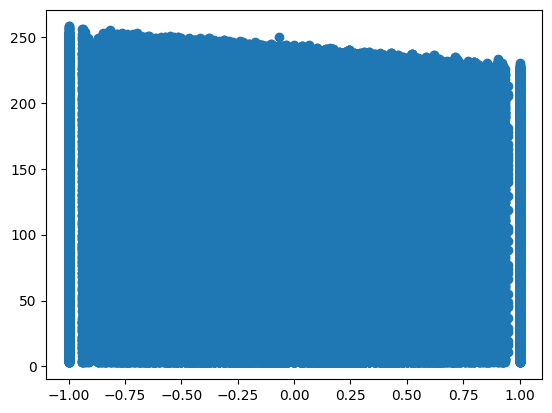

num runs 12700 12700


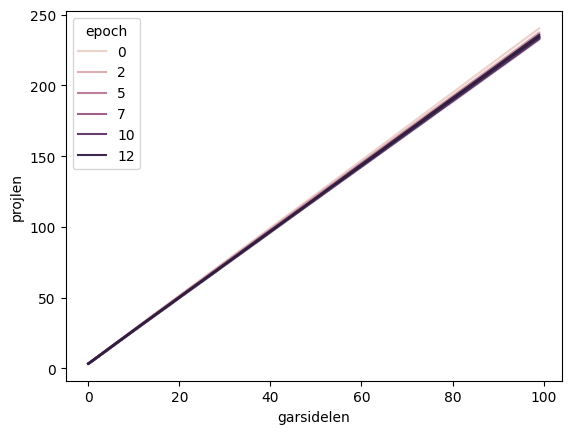

projlens (12700, 100)


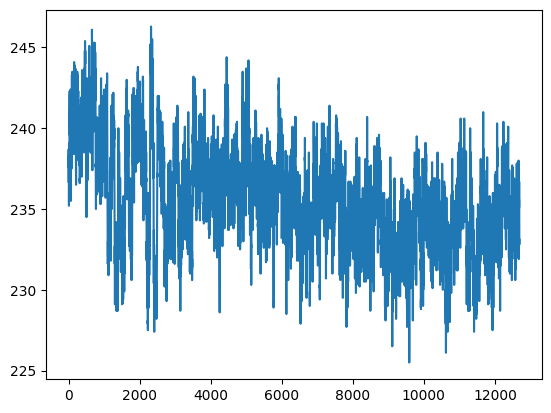

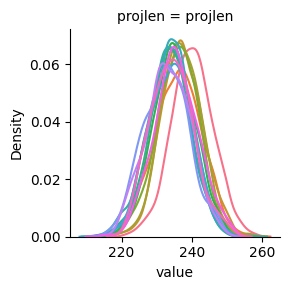

In [254]:
_, pis, vs, ps = zip(*iterationTrainExamples)
N=100
plt.plot(np.convolve(vs[::100], np.ones(N)/N, mode='valid'))
plt.show() 
plt.scatter(vs,ps)
plt.show() 
projlens = []
actions = []
for action_lists_projlen in action_lists_projlens:
    projs = action_lists_projlen["projlens"]
    actions.append (np.array(action_lists_projlen["action_lists"]))
#     for proj in projs[-5:]:
#         print (proj)
#     print (projs.T)
    projlens.extend(projs.T)
print ("num runs", len(projlens), len(epochs))
df = pd.DataFrame({"projlen":np.concatenate(projlens).flatten(), "epoch":np.array(epochs).repeat(projlens[0].shape[0]),
                   "garsidelen" : np.array([list(range(projlens[0].shape[0])) for i in range(len(projlens))]).flatten(),
                   })
sns.lineplot(x="garsidelen", y="projlen", hue="epoch", data=df)
plt.show()
print("projlens", np.stack(projlens).shape)
N=10; plt.plot(np.convolve(np.stack(projlens)[:,-1], np.ones(N)/N, mode='valid'))
plt.show() 
df = pd.DataFrame({"projlen":np.stack(projlens)[:,-1].flatten(), "epoch":epochs,
 
                   })
plt.figure(figsize=(10,10))
g = sns.FacetGrid(df.melt(["epoch"], var_name="projlen"), col="projlen", hue="epoch", sharey=False)
g.map(sns.kdeplot, "value")
plt.show()

<Figure size 1000x1000 with 0 Axes>

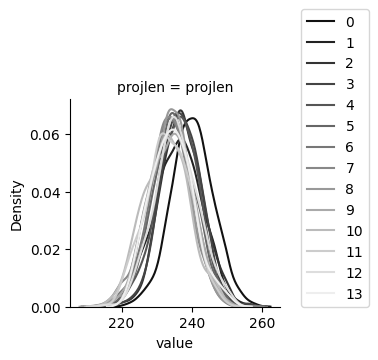

In [259]:
plt.figure(figsize=(10,10))
g = sns.FacetGrid(df.melt(["epoch"], var_name="projlen"), col="projlen", hue="epoch", sharey=False,palette="gray")
g.map(sns.kdeplot, "value")
plt.legend(loc=(1.1,0))
plt.show()

In [260]:
# check duplication
print(np.concatenate(actions).shape)
unq, count = np.unique(np.concatenate(actions), axis=0, return_counts=True)
unq[count>1]

(12700, 100)


array([[ 1,  1,  1, ...,  9,  4, 12],
       [ 1,  1,  1, ..., 12,  6,  6],
       [ 1,  1,  1, ..., 12,  6,  8],
       ...,
       [22, 16, 16, ...,  8, 12,  6],
       [22, 16, 16, ...,  6,  8,  2],
       [22, 16, 16, ...,  4,  2, 16]])

In [262]:
unq[count>1].shape, len(count[count>1])

((1500, 100), 1500)

In [213]:
pi_losses,v_losses = [], []
for action_lists_projlen in action_lists_projlens:
    pi_losses.append(action_lists_projlen["pi_loss"])
    v_losses.append(action_lists_projlen["v_loss"])
print(pi_losses)
print(v_losses)

[1.5275783451394964, 2.1080756477928464, 1.5020150043337808, 1.514404145078209, 1.4980605057465821, 1.6231865951221793, 1.505519210038835, 1.6830920415741812, 1.5629020129314821, 1.5151356408230099, 1.463547620701187, 1.4193301678803096, 1.4413658333644186, 1.4252978463621286, 1.4221909394302037, 1.4466405013773438, 1.4433418462172056, 1.4574415011118211, 1.444168757529514, 1.4439761839111198, 1.4730446184960848, 1.424160588840049, 1.4476434419183966, 1.415298527105877, 1.4222927828299663, 1.417799403219633, 1.4421222993453986, 1.418717120691146, 1.422305687319452, 1.4302910129315887, 1.436572201511784, 1.4362527721421938, 1.436184640105463, 1.4390370286772614, 1.4419819160656364, 1.4423118474643943, 1.4432037987269624, 1.4469635619465366, 1.4409920482043415, 1.4430037130174131, 1.44232864105122, 1.4334436490931193, 1.4344234638199742, 1.4298337606911413, 1.4312808578859126, 1.444171730311499, 1.4339260787634325, 1.439298642557228, 1.4434989502059814, 1.45253374847118, 1.43423839596176

# Check that projlen computed in program is same as projlen computed

In [42]:
import operator
import functools
from typing import Sequence
print(action_lists_projlens[i]['action_lists'][-1])
print(action_lists_projlens[i]['projlens'][-1])
acts = action_lists_projlens[i]['action_lists'][-1]
projs = action_lists_projlens[i]['projlens'][-1]
gen_lookup_table = {} 
nft = PermTable.create(n=4)
BG = BraidGroup(4)
mod_p = 3
cell_rep = JonesCellRep(n=4, r=1, p=mod_p)
def perms_to_braid(BG: BraidGroup, perms: Sequence[Permutation]) -> GNF:
    return functools.reduce(operator.mul, [BG.positive_lift(perm) for perm in perms], BG.id())

for i, gen in enumerate(nft.divs):
    gen_lookup_table[i] = polymat.from_matrix(cell_rep.evaluate(perms_to_braid(BG, [gen])), proj=True)
    gen_lookup_table[i] = polymat.trim(gen_lookup_table[i])  
board = polymat.eye(3)
projlens_mine = []
for i in range(len(acts)):
    display (polymat.to_matrix(polymat.trim(board)))
    
    board = polymat.trim(board)
    board = polymat.trim(polymat.mul(board, gen_lookup_table[acts[i]])) 
    board = np.mod(board, mod_p)
    projlens_mine.append(polymat.projlen(board))
    print ("acts[i]", acts[i], projs[i], projlens_mine[i])
print (projlens_mine)
print(projs)


[3, 1, 1, 4, 2, 13, 1, 1, 18, 9, 1, 4, 2, 16, 2, 12, 9, 4, 13, 1, 18, 9, 1, 4, 3, 18, 9, 1, 4, 3, 18, 9, 1, 1, 1, 18, 8, 13, 11, 4, 12, 8, 3, 18, 9, 4, 16, 3, 4, 2, 12, 8, 13, 20, 2, 3, 4, 13, 10, 2, 2, 13, 9, 1, 18, 9, 4, 3, 4, 2, 13, 1, 4, 2, 16, 13, 1, 1, 4, 13, 11, 2, 16, 13, 9, 1, 18, 6, 6, 8, 2, 13, 1, 18, 9, 18, 9, 4, 13, 8]
[4, 6, 8, 11, 13, 15, 17, 19, 22, 25, 27, 29, 31, 33, 35, 37, 40, 43, 45, 47, 50, 53, 55, 57, 59, 62, 65, 67, 69, 72, 75, 78, 80, 82, 84, 87, 89, 91, 94, 97, 99, 101, 104, 107, 110, 113, 115, 117, 119, 121, 124, 127, 129, 132, 133, 135, 137, 139, 141, 143, 145, 147, 150, 152, 155, 158, 161, 164, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185, 187, 189, 192, 193, 195, 197, 200, 202, 205, 207, 209, 211, 213, 215, 217, 220, 223, 226, 229, 231, 233, 235]


Matrix([
    [LPoly('1'), LPoly('0'), LPoly('0')],
    [LPoly('0'), LPoly('1'), LPoly('0')],
    [LPoly('0'), LPoly('0'), LPoly('1')],
])

acts[i] 3 4 4


Matrix([
    [LPoly('1'), LPoly('0'), LPoly('0')],
    [LPoly('2v'), LPoly('0'), LPoly('v^3')],
    [LPoly('0'), LPoly('2v'), LPoly('2v^2')],
])

acts[i] 1 6 6


Matrix([
    [LPoly('1'), LPoly('0'), LPoly('0')],
    [LPoly('2v'), LPoly('2v^4'), LPoly('2v^5')],
    [LPoly('0'), LPoly('v^3 + 2v'), LPoly('v^4')],
])

acts[i] 1 8 8


Matrix([
    [LPoly('1'), LPoly('0'), LPoly('0')],
    [LPoly('2v'), LPoly('v^6 + 2v^4'), LPoly('v^7')],
    [LPoly('0'), LPoly('2v^5 + v^3 + 2v'), LPoly('2v^6')],
])

acts[i] 4 11 11


Matrix([
    [LPoly('1'), LPoly('0'), LPoly('0')],
    [LPoly('v^9 + 2v^7 + v^5 + 2v'), LPoly('v^10 + 2v^8 + v^6'), LPoly('2v^7 + v^5')],
    [LPoly('2v^8 + v^6 + 2v^4 + v^2'), LPoly('2v^9 + v^7 + 2v^5 + v^3'), LPoly('v^6 + 2v^4 + v^2')],
])

acts[i] 2 13 13


Matrix([
    [LPoly('1'), LPoly('0'), LPoly('0')],
    [LPoly('2v^11 + 2v^9 + v^7 + v^5 + 2v'), LPoly('2v^12 + v^10 + 2v^8'), LPoly('2v^11 + v^9 + v^7 + v^5')],
    [LPoly('v^10 + v^8 + 2v^6 + v^4 + v^2'), LPoly('v^11 + 2v^9 + v^7 + 2v^5'), LPoly('v^10 + 2v^8 + 2v^6 + v^4 + v^2')],
])

acts[i] 13 15 15


Matrix([
    [LPoly('2v^2'), LPoly('2v'), LPoly('0')],
    [LPoly('2v^15 + 2v^13 + 2v^9 + 2v^7 + v^3'), LPoly('2v^14 + 2v^10 + v^8 + v^6 + v^2'), LPoly('2v^15 + 2v^13 + v^11 + 2v^9 + 2v^7')],
    [LPoly('v^14 + v^12 + 2v^6 + 2v^4'), LPoly('v^13 + v^9 + v^7 + v^5 + v^3'), LPoly('v^14 + v^12 + 2v^10 + 2v^6 + 2v^4')],
])

acts[i] 1 17 17


Matrix([
    [LPoly('2v^2'), LPoly('2v'), LPoly('0')],
    [LPoly('2v^15 + 2v^13 + 2v^9 + 2v^7 + v^3'), LPoly('v^16 + 2v^12 + 2v^8 + v^6 + v^2'), LPoly('v^17 + v^15 + 2v^13 + v^11 + v^9')],
    [LPoly('v^14 + v^12 + 2v^6 + 2v^4'), LPoly('2v^15 + v^11 + v^9 + 2v^7 + 2v^5 + v^3'), LPoly('2v^16 + 2v^14 + v^12 + v^8 + v^6')],
])

acts[i] 1 19 19


Matrix([
    [LPoly('2v^2'), LPoly('2v'), LPoly('0')],
    [LPoly('2v^15 + 2v^13 + 2v^9 + 2v^7 + v^3'), LPoly('2v^18 + v^14 + v^12 + 2v^10 + 2v^8 + v^6 + v^2'), LPoly('2v^19 + 2v^17 + v^15 + 2v^13 + 2v^11')],
    [LPoly('v^14 + v^12 + 2v^6 + 2v^4'), LPoly('v^17 + 2v^13 + v^11 + v^7 + 2v^5 + v^3'), LPoly('v^18 + v^16 + 2v^14 + 2v^10 + 2v^8')],
])

acts[i] 18 22 22


Matrix([
    [LPoly('0'), LPoly('v^3'), LPoly('v^2')],
    [LPoly('v^23 + 2v^19 + 2v^13 + 2v^9'), LPoly('v^16 + v^14 + v^10 + v^8 + 2v^4'), LPoly('v^19 + 2v^15 + 2v^13 + v^11 + v^9 + 2v^7 + 2v^3')],
    [LPoly('2v^22 + v^18 + v^16 + v^14 + v^12 + v^10 + 2v^6'), LPoly('2v^15 + 2v^13 + v^7 + v^5'), LPoly('2v^18 + v^14 + 2v^12 + 2v^8 + v^6 + 2v^4')],
])

acts[i] 9 25 25


Matrix([
    [LPoly('2v^4'), LPoly('2v^3'), LPoly('v^6 + 2v^4')],
    [LPoly('2v^17 + 2v^15 + 2v^11 + 2v^9 + v^5'), LPoly('2v^20 + v^16 + v^14 + 2v^12 + 2v^10 + v^8 + v^4'), LPoly('2v^27 + v^23 + 2v^21 + v^19 + v^15 + v^13 + v^9 + 2v^7 + v^5')],
    [LPoly('v^16 + v^14 + 2v^8 + 2v^6'), LPoly('v^19 + 2v^15 + v^13 + v^9 + 2v^7 + v^5'), LPoly('v^26 + 2v^22 + v^18 + v^6')],
])

acts[i] 1 27 27


Matrix([
    [LPoly('2v^4'), LPoly('2v^7 + v^5 + 2v^3'), LPoly('2v^8 + v^6')],
    [LPoly('2v^17 + 2v^15 + 2v^11 + 2v^9 + v^5'), LPoly('v^28 + 2v^24 + v^22 + v^20 + 2v^12 + v^10 + 2v^8 + 2v^6 + v^4'), LPoly('v^29 + 2v^25 + v^23 + 2v^21 + 2v^17 + 2v^15 + 2v^11 + v^9 + 2v^7')],
    [LPoly('v^16 + v^14 + 2v^8 + 2v^6'), LPoly('2v^27 + v^23 + 2v^15 + v^13 + v^9 + v^7 + v^5'), LPoly('2v^28 + v^24 + 2v^20 + 2v^8')],
])

acts[i] 4 29 29


Matrix([
    [LPoly('2v^10 + 2v^8 + 2v^6'), LPoly('2v^11 + 2v^9 + 2v^7 + v^5'), LPoly('v^8 + 2v^6 + v^4')],
    [LPoly('v^31 + 2v^29 + 2v^27 + 2v^25 + v^23 + 2v^21 + 2v^19 + v^17 + 2v^15 + 2v^11 + 2v^9 + v^7'), LPoly('v^32 + 2v^30 + 2v^28 + 2v^26 + v^24 + 2v^22 + 2v^20 + 2v^18 + v^8 + 2v^6'), LPoly('2v^29 + v^25 + 2v^23 + 2v^21 + v^13 + 2v^11 + v^9 + v^7 + 2v^5')],
    [LPoly('2v^30 + v^28 + v^26 + 2v^24 + 2v^22 + 2v^16 + v^10 + v^8 + v^6'), LPoly('2v^31 + v^29 + v^27 + 2v^25 + 2v^23 + v^17 + 2v^15 + v^11 + 2v^9 + 2v^7'), LPoly('v^28 + 2v^24 + v^16 + 2v^14 + 2v^10 + 2v^8 + 2v^6')],
])

acts[i] 2 31 31


Matrix([
    [LPoly('v^12 + v^6'), LPoly('v^13 + v^11 + v^9 + 2v^7'), LPoly('v^12 + v^10 + 2v^8 + v^6 + v^4')],
    [LPoly('2v^33 + 2v^31 + v^25 + 2v^23 + v^17 + 2v^15 + 2v^11 + v^9 + 2v^7'), LPoly('2v^34 + v^32 + v^30 + v^28 + 2v^26 + v^24 + v^22 + v^20 + 2v^10 + v^8'), LPoly('2v^33 + v^31 + v^27 + v^19 + v^13 + 2v^11 + 2v^7 + 2v^5')],
    [LPoly('v^32 + v^30 + 2v^26 + 2v^22 + 2v^18 + 2v^12 + 2v^10 + 2v^8 + v^6'), LPoly('v^33 + 2v^31 + 2v^29 + v^27 + v^25 + 2v^19 + v^17 + 2v^13 + v^11 + v^9'), LPoly('v^32 + 2v^30 + v^26 + 2v^18 + 2v^16 + 2v^14 + 2v^12 + 2v^6')],
])

acts[i] 16 33 33


Matrix([
    [LPoly('v^14 + v^12 + 2v^10 + v^8 + v^6'), LPoly('2v^17 + v^15 + 2v^9 + v^7'), LPoly('v^14 + v^8')],
    [LPoly('2v^35 + v^33 + v^29 + v^21 + v^15 + 2v^13 + 2v^9 + 2v^7'), LPoly('v^38 + 2v^34 + 2v^32 + 2v^30 + v^26 + 2v^24 + v^22 + v^20 + 2v^18 + v^16 + 2v^14 + v^10 + 2v^8'), LPoly('2v^35 + 2v^33 + v^27 + 2v^25 + v^19 + 2v^17 + 2v^13 + v^11 + 2v^9')],
    [LPoly('v^34 + 2v^32 + v^28 + 2v^20 + 2v^18 + 2v^16 + 2v^14 + 2v^8'), LPoly('2v^37 + v^33 + 2v^31 + 2v^29 + 2v^25 + v^23 + 2v^19 + v^13 + 2v^11'), LPoly('v^34 + v^32 + 2v^28 + 2v^24 + 2v^20 + 2v^14 + 2v^12 + 2v^10 + v^8')],
])

acts[i] 2 35 35


Matrix([
    [LPoly('v^18 + 2v^16 + v^14 + v^12 + v^6'), LPoly('v^19 + 2v^17 + v^11 + 2v^9'), LPoly('v^18 + 2v^16 + v^14 + v^10')],
    [LPoly('2v^39 + 2v^33 + v^31 + v^29 + 2v^27 + v^25 + 2v^23 + v^19 + 2v^17 + 2v^15 + 2v^13 + 2v^11 + 2v^7'), LPoly('2v^40 + v^36 + v^34 + v^32 + 2v^28 + v^26 + 2v^24 + 2v^22 + v^20 + 2v^18 + v^16 + 2v^12 + v^10'), LPoly('2v^39 + v^31 + 2v^23 + 2v^21 + 2v^19 + v^17 + v^15 + 2v^13')],
    [LPoly('v^38 + v^30 + v^28 + v^26 + 2v^24 + 2v^18 + 2v^16 + v^14 + v^12 + 2v^8'), LPoly('v^39 + 2v^35 + v^33 + v^31 + v^27 + 2v^25 + v^21 + 2v^15 + v^13'), LPoly('v^38 + 2v^32 + v^30 + 2v^28 + v^26 + v^24 + v^14 + 2v^10 + v^8')],
])

acts[i] 12 37 37


Matrix([
    [LPoly('v^22 + v^20 + v^18 + 2v^16 + 2v^12 + 2v^8'), LPoly('2v^19 + v^17 + 2v^15 + 2v^13 + 2v^7'), LPoly('2v^20 + 2v^18 + 2v^16 + v^14 + 2v^12 + 2v^10')],
    [LPoly('2v^43 + v^41 + v^39 + v^37 + 2v^35 + 2v^33 + v^31 + 2v^29 + v^27 + v^23 + v^21 + 2v^19 + v^17 + 2v^13 + v^9'), LPoly('v^40 + v^34 + 2v^32 + 2v^30 + v^28 + 2v^26 + v^24 + 2v^20 + v^18 + v^16 + v^14 + v^12 + v^8'), LPoly('v^41 + 2v^39 + 2v^37 + 2v^35 + 2v^33 + v^31 + v^29 + 2v^27 + v^25 + v^21 + v^15 + 2v^11')],
    [LPoly('v^42 + 2v^40 + 2v^38 + v^36 + v^34 + 2v^32 + v^28 + v^26 + v^24 + v^20 + 2v^14 + v^10'), LPoly('2v^39 + 2v^31 + 2v^29 + 2v^27 + v^25 + v^19 + v^17 + 2v^15 + 2v^13 + v^9'), LPoly('2v^40 + v^38 + v^36 + 2v^34 + v^32 + v^30 + v^28 + 2v^26 + v^24 + 2v^22 + v^16 + 2v^10 + v^8')],
])

acts[i] 9 40 40


Matrix([
    [LPoly('v^20 + 2v^18 + v^16 + v^14 + v^8'), LPoly('v^21 + v^19 + v^17 + 2v^15 + v^13 + v^11'), LPoly('2v^26 + 2v^24 + 2v^22 + 2v^16 + v^14 + 2v^12 + 2v^10')],
    [LPoly('2v^41 + 2v^35 + v^33 + v^31 + 2v^29 + v^27 + 2v^25 + v^21 + 2v^19 + 2v^17 + 2v^15 + 2v^13 + 2v^9'), LPoly('2v^42 + v^40 + v^38 + v^36 + v^34 + 2v^32 + 2v^30 + v^28 + 2v^26 + 2v^22 + 2v^16 + v^12'), LPoly('v^47 + 2v^45 + 2v^43 + 2v^39 + 2v^35 + 2v^33 + 2v^31 + 2v^27 + 2v^25 + 2v^23 + v^19 + v^17 + v^15 + v^11')],
    [LPoly('v^40 + v^32 + v^30 + v^28 + 2v^26 + 2v^20 + 2v^18 + v^16 + v^14 + 2v^10'), LPoly('v^41 + 2v^39 + 2v^37 + v^35 + 2v^33 + 2v^31 + 2v^29 + v^27 + 2v^25 + v^23 + 2v^17 + v^11 + 2v^9'), LPoly('2v^46 + v^44 + v^42 + v^40 + v^38 + 2v^36 + v^34 + v^28 + 2v^26 + v^22 + v^20 + 2v^18 + 2v^16 + 2v^14 + 2v^12 + 2v^10')],
])

acts[i] 4 43 43


Matrix([
    [LPoly('2v^28 + 2v^26 + 2v^24 + 2v^22 + 2v^14 + v^12 + v^8'), LPoly('2v^29 + 2v^27 + 2v^25 + 2v^23 + 2v^21 + v^19 + 2v^17 + v^15 + v^13'), LPoly('2v^22 + 2v^20 + 2v^18 + v^16 + 2v^14 + 2v^12')],
    [LPoly('v^49 + 2v^47 + 2v^45 + v^43 + 2v^39 + v^37 + v^33 + 2v^31 + v^27 + v^25 + v^23 + 2v^21 + v^17 + 2v^15 + 2v^13 + 2v^9'), LPoly('v^50 + 2v^48 + 2v^46 + v^44 + v^42 + 2v^40 + v^38 + v^36 + v^32 + v^30 + 2v^26 + v^24 + v^22 + v^20 + 2v^18'), LPoly('v^43 + 2v^41 + 2v^39 + 2v^37 + 2v^35 + v^33 + v^31 + 2v^29 + v^27 + v^23 + v^17 + 2v^13')],
    [LPoly('2v^48 + v^46 + v^44 + v^34 + 2v^32 + 2v^28 + v^22 + v^20 + 2v^18 + v^12'), LPoly('2v^49 + v^47 + v^45 + 2v^41 + v^35 + v^33 + 2v^31 + v^29 + v^27 + v^23 + 2v^21 + 2v^17 + 2v^15 + v^13 + v^11'), LPoly('2v^42 + v^40 + v^38 + 2v^36 + v^34 + v^32 + v^30 + 2v^28 + v^26 + 2v^24 + v^18 + 2v^12 + v^10')],
])

acts[i] 13 45 45


Matrix([
    [LPoly('2v^32 + v^22 + 2v^20 + v^18 + 2v^16 + 2v^14 + 2v^10'), LPoly('2v^31 + v^23 + 2v^21 + 2v^9'), LPoly('2v^32 + 2v^30 + 2v^28 + 2v^26 + 2v^22 + 2v^16 + v^14')],
    [LPoly('v^53 + v^51 + 2v^47 + 2v^43 + 2v^41 + 2v^33 + v^29 + 2v^23 + 2v^21 + 2v^19 + v^17 + v^15 + v^11'), LPoly('v^52 + v^50 + 2v^46 + 2v^44 + v^38 + v^36 + 2v^34 + v^32 + v^30 + 2v^24 + 2v^22 + 2v^20 + v^18 + v^16 + 2v^14 + v^10'), LPoly('v^53 + 2v^51 + 2v^49 + v^47 + 2v^41 + 2v^39 + v^37 + v^31 + v^29 + v^27 + v^23 + 2v^21 + 2v^19 + v^15')],
    [LPoly('2v^52 + 2v^50 + 2v^46 + 2v^44 + v^38 + v^32 + 2v^30 + v^26 + v^24 + 2v^22 + 2v^18 + v^16'), LPoly('2v^51 + 2v^49 + 2v^45 + 2v^41 + 2v^39 + 2v^37 + 2v^35 + 2v^33 + 2v^27 + 2v^25 + v^23 + 2v^21 + 2v^19 + 2v^17 + v^15 + v^13 + 2v^11'), LPoly('2v^52 + v^50 + v^48 + 2v^42 + 2v^40 + 2v^38 + v^34 + 2v^30 + 2v^28 + 2v^26 + 2v^24 + v^20 + 2v^18 + v^16 + 2v^14 + 2v^12')],
])

acts[i] 1 47 47


Matrix([
    [LPoly('2v^32 + v^22 + 2v^20 + v^18 + 2v^16 + 2v^14 + 2v^10'), LPoly('v^33 + v^29 + v^27 + 2v^23 + 2v^21 + v^17 + 2v^15 + 2v^9'), LPoly('v^34 + v^32 + v^30 + v^28 + v^24 + v^18 + 2v^16')],
    [LPoly('v^53 + v^51 + 2v^47 + 2v^43 + 2v^41 + 2v^33 + v^29 + 2v^23 + 2v^21 + 2v^19 + v^17 + v^15 + v^11'), LPoly('2v^54 + 2v^52 + 2v^50 + 2v^48 + 2v^46 + 2v^44 + v^42 + v^40 + v^36 + 2v^34 + 2v^28 + v^24 + v^18 + 2v^14 + v^10'), LPoly('2v^55 + v^53 + v^51 + 2v^49 + v^43 + v^41 + 2v^39 + 2v^33 + 2v^31 + 2v^29 + 2v^25 + v^23 + v^21 + 2v^17')],
    [LPoly('2v^52 + 2v^50 + 2v^46 + 2v^44 + v^38 + v^32 + 2v^30 + v^26 + v^24 + 2v^22 + 2v^18 + v^16'), LPoly('v^53 + v^51 + v^49 + 2v^45 + v^43 + 2v^37 + v^35 + 2v^33 + v^31 + v^29 + v^23 + v^21 + v^17 + 2v^15 + 2v^13 + 2v^11'), LPoly('v^54 + 2v^52 + 2v^50 + v^44 + v^42 + v^40 + 2v^36 + v^32 + v^30 + v^28 + v^26 + 2v^22 + v^20 + 2v^18 + v^16 + v^14')],
])

acts[i] 18 50 50


Matrix([
    [LPoly('2v^38 + v^30 + 2v^28 + 2v^26 + v^24 + v^20 + v^16'), LPoly('v^33 + 2v^23 + v^21 + 2v^19 + v^17 + v^15 + v^11'), LPoly('2v^34 + 2v^30 + 2v^28 + v^24 + v^22 + 2v^18 + v^16 + v^10')],
    [LPoly('v^59 + v^57 + 2v^53 + 2v^51 + v^47 + v^45 + v^39 + 2v^35 + v^33 + v^31 + v^29 + v^23 + 2v^19 + v^17'), LPoly('2v^54 + 2v^52 + v^48 + v^44 + v^42 + v^34 + 2v^30 + v^24 + v^22 + v^20 + 2v^18 + 2v^16 + 2v^12'), LPoly('v^55 + v^53 + v^51 + v^49 + v^47 + v^45 + 2v^43 + 2v^41 + 2v^37 + v^35 + v^29 + 2v^25 + 2v^19 + v^15 + 2v^11')],
    [LPoly('2v^58 + 2v^56 + 2v^52 + 2v^48 + v^46 + 2v^44 + 2v^40 + v^38 + v^36 + 2v^34 + v^32 + 2v^30 + 2v^28 + v^26 + v^24 + v^22 + v^20 + 2v^16 + 2v^14'), LPoly('v^53 + v^51 + v^47 + v^45 + 2v^39 + 2v^33 + v^31 + 2v^27 + 2v^25 + v^23 + v^19 + 2v^17'), LPoly('2v^54 + 2v^52 + 2v^50 + v^46 + 2v^44 + v^38 + 2v^36 + v^34 + 2v^32 + 2v^30 + 2v^24 + 2v^22 + 2v^18 + v^16 + v^14 + v^12')],
])

acts[i] 9 53 53


Matrix([
    [LPoly('2v^34 + v^24 + 2v^22 + v^20 + 2v^18 + 2v^16 + 2v^12'), LPoly('v^35 + v^31 + v^29 + 2v^25 + 2v^23 + v^19 + 2v^17 + 2v^11'), LPoly('v^42 + 2v^36 + 2v^34 + 2v^32 + 2v^30 + 2v^28 + v^26 + 2v^24 + 2v^22 + v^20 + v^14 + 2v^12')],
    [LPoly('v^55 + v^53 + 2v^49 + 2v^45 + 2v^43 + 2v^35 + v^31 + 2v^25 + 2v^23 + 2v^21 + v^19 + v^17 + v^13'), LPoly('2v^56 + 2v^54 + 2v^52 + 2v^50 + 2v^48 + 2v^46 + v^44 + v^42 + v^38 + 2v^36 + 2v^30 + v^26 + v^20 + 2v^16 + v^12'), LPoly('2v^63 + 2v^61 + 2v^57 + 2v^55 + 2v^53 + 2v^51 + v^49 + 2v^45 + 2v^39 + 2v^37 + 2v^35 + v^33 + 2v^31 + v^27 + v^25 + 2v^23 + 2v^21 + 2v^19 + 2v^17 + 2v^15 + v^13')],
    [LPoly('2v^54 + 2v^52 + 2v^48 + 2v^46 + v^40 + v^34 + 2v^32 + v^28 + v^26 + 2v^24 + 2v^20 + v^18'), LPoly('v^55 + v^53 + v^51 + 2v^47 + v^45 + 2v^39 + v^37 + 2v^35 + v^33 + v^31 + v^25 + v^23 + v^19 + 2v^17 + 2v^15 + 2v^13'), LPoly('v^62 + v^60 + 2v^54 + 2v^52 + v^48 + v^46 + v^44 + v^42 + v^40 + 2v^38 + 2v^32 + v^30 + v^28 + v^26 + v^22 + v^20

acts[i] 1 55 55


Matrix([
    [LPoly('2v^34 + v^24 + 2v^22 + v^20 + 2v^18 + 2v^16 + 2v^12'), LPoly('2v^43 + v^37 + 2v^35 + v^33 + 2v^31 + 2v^29 + 2v^27 + 2v^21 + v^19 + 2v^17 + 2v^15 + v^13 + 2v^11'), LPoly('2v^44 + v^38 + v^36 + v^34 + v^32 + v^30 + 2v^28 + v^26 + v^24 + 2v^22 + 2v^16 + v^14')],
    [LPoly('v^55 + v^53 + 2v^49 + 2v^45 + 2v^43 + 2v^35 + v^31 + 2v^25 + 2v^23 + 2v^21 + v^19 + v^17 + v^13'), LPoly('v^64 + v^62 + v^58 + v^50 + 2v^48 + v^44 + v^42 + v^40 + 2v^38 + 2v^34 + v^32 + 2v^30 + 2v^28 + v^24 + v^22 + 2v^20 + v^18 + 2v^14 + v^12'), LPoly('v^65 + v^63 + v^59 + v^57 + v^55 + v^53 + 2v^51 + v^47 + v^41 + v^39 + v^37 + 2v^35 + v^33 + 2v^29 + 2v^27 + v^25 + v^23 + v^21 + v^19 + v^17 + 2v^15')],
    [LPoly('2v^54 + 2v^52 + 2v^48 + 2v^46 + v^40 + v^34 + 2v^32 + v^28 + v^26 + 2v^24 + 2v^20 + v^18'), LPoly('2v^63 + 2v^61 + 2v^55 + 2v^53 + v^51 + 2v^49 + v^47 + 2v^43 + 2v^41 + v^37 + 2v^35 + 2v^33 + 2v^29 + 2v^27 + v^25 + 2v^21 + v^19 + 2v^13'), LPoly('2v^64 + 2v^62 + v^56 + v^54 + 2v^50 + 2v^

acts[i] 4 57 57


Matrix([
    [LPoly('2v^46 + v^44 + v^40 + 2v^36 + 2v^34 + 2v^32 + 2v^28 + v^26 + 2v^18 + v^16 + 2v^14'), LPoly('2v^47 + v^45 + v^41 + 2v^37 + 2v^33 + 2v^29 + v^27 + 2v^25 + v^23 + 2v^21 + 2v^17 + 2v^15 + v^13'), LPoly('v^44 + 2v^38 + v^36 + 2v^34 + v^32 + v^30 + v^28 + v^22 + 2v^20 + v^18 + v^16 + 2v^14 + v^12')],
    [LPoly('v^67 + 2v^63 + v^61 + v^57 + 2v^55 + 2v^51 + v^49 + v^45 + 2v^43 + 2v^39 + 2v^37 + v^35 + 2v^33 + v^31 + v^27 + 2v^25 + 2v^23 + v^21 + v^19 + v^15'), LPoly('v^68 + 2v^64 + v^62 + v^58 + v^56 + 2v^54 + 2v^52 + 2v^50 + 2v^46 + 2v^40 + 2v^38 + 2v^36 + 2v^34 + v^28 + 2v^22 + 2v^18 + v^16 + 2v^14'), LPoly('2v^65 + 2v^63 + 2v^59 + 2v^51 + v^49 + 2v^45 + 2v^43 + 2v^41 + v^39 + v^35 + 2v^33 + v^31 + v^29 + 2v^25 + 2v^23 + v^21 + 2v^19 + v^15 + 2v^13')],
    [LPoly('2v^66 + v^62 + v^58 + 2v^56 + v^46 + 2v^42 + v^40 + 2v^38 + 2v^36 + v^34 + v^32 + 2v^28 + 2v^26 + v^24 + v^22 + 2v^20 + 2v^18 + v^14'), LPoly('2v^67 + v^63 + v^59 + 2v^57 + v^55 + v^53 + v^49 + 2v^47 + 2v^43 +

acts[i] 3 59 59


Matrix([
    [LPoly('v^48 + v^46 + v^44 + 2v^42 + v^40 + v^38 + 2v^36 + 2v^32 + v^30 + v^28 + 2v^26 + 2v^24 + v^22 + 2v^16 + v^14'), LPoly('2v^45 + v^39 + 2v^37 + v^35 + 2v^33 + 2v^31 + 2v^29 + 2v^23 + v^21 + 2v^19 + 2v^17 + v^15 + 2v^13'), LPoly('2v^50 + v^48 + 2v^46 + v^44 + 2v^38 + 2v^34 + v^32 + 2v^28 + v^26 + v^24 + v^22 + v^20 + v^18 + 2v^16 + 2v^14')],
    [LPoly('2v^69 + v^67 + v^65 + v^63 + v^61 + 2v^59 + v^53 + v^49 + v^47 + v^45 + 2v^43 + v^41 + 2v^35 + 2v^33 + v^31 + 2v^29 + v^27 + 2v^25 + v^21 + 2v^19 + 2v^17 + 2v^15'), LPoly('v^66 + v^64 + v^60 + v^52 + 2v^50 + v^46 + v^44 + v^42 + 2v^40 + 2v^36 + v^34 + 2v^32 + 2v^30 + v^26 + v^24 + 2v^22 + v^20 + 2v^16 + v^14'), LPoly('v^71 + 2v^65 + 2v^61 + v^59 + 2v^57 + 2v^55 + 2v^51 + 2v^49 + v^47 + v^45 + v^41 + 2v^39 + v^37 + v^35 + 2v^33 + v^27 + 2v^23 + v^19 + v^17 + v^15')],
    [LPoly('v^68 + 2v^66 + 2v^64 + v^62 + 2v^60 + 2v^58 + v^56 + 2v^54 + 2v^50 + v^48 + v^46 + v^44 + 2v^42 + 2v^40 + 2v^36 + 2v^34 + v^32 + 2v^30 + v^28 +

acts[i] 18 62 62


Matrix([
    [LPoly('v^54 + 2v^52 + 2v^46 + v^44 + v^42 + v^40 + v^36 + 2v^32 + v^30 + 2v^26 + 2v^24 + v^22 + v^16'), LPoly('2v^49 + 2v^47 + 2v^45 + v^43 + 2v^41 + 2v^39 + v^37 + v^33 + 2v^31 + 2v^29 + v^27 + v^25 + 2v^23 + v^17 + 2v^15'), LPoly('v^46 + 2v^40 + v^38 + 2v^36 + v^34 + v^32 + v^30 + v^24 + 2v^22 + v^20 + v^18 + 2v^16 + v^14')],
    [LPoly('2v^75 + v^71 + v^69 + 2v^63 + 2v^61 + v^59 + v^55 + v^51 + 2v^49 + v^45 + 2v^43 + 2v^41 + v^39 + v^33 + 2v^25 + 2v^23 + 2v^19 + 2v^17'), LPoly('v^70 + 2v^68 + 2v^66 + 2v^64 + 2v^62 + v^60 + 2v^54 + 2v^50 + 2v^48 + 2v^46 + v^44 + 2v^42 + v^36 + v^34 + 2v^32 + v^30 + 2v^28 + v^26 + 2v^22 + v^20 + v^18 + v^16'), LPoly('2v^67 + 2v^65 + 2v^61 + 2v^53 + v^51 + 2v^47 + 2v^45 + 2v^43 + v^41 + v^37 + 2v^35 + v^33 + v^31 + 2v^27 + 2v^25 + v^23 + 2v^21 + v^17 + 2v^15')],
    [LPoly('v^74 + 2v^70 + v^68 + 2v^66 + v^62 + 2v^56 + 2v^54 + 2v^52 + v^50 + 2v^48 + 2v^46 + v^44 + v^40 + v^36 + v^34 + 2v^30 + v^28 + v^22 + 2v^20 + 2v^16'), LPoly('2v^69 + v

acts[i] 9 65 65


Matrix([
    [LPoly('v^50 + v^48 + v^46 + 2v^44 + v^42 + v^40 + 2v^38 + 2v^34 + v^32 + v^30 + 2v^28 + 2v^26 + v^24 + 2v^18 + v^16'), LPoly('2v^47 + v^41 + 2v^39 + v^37 + 2v^35 + 2v^33 + 2v^31 + 2v^25 + v^23 + 2v^21 + 2v^19 + v^17 + 2v^15'), LPoly('2v^58 + v^56 + 2v^52 + v^44 + 2v^40 + v^38 + v^36 + v^32 + 2v^30 + 2v^28 + v^24 + 2v^22 + 2v^20 + 2v^16')],
    [LPoly('2v^71 + v^69 + v^67 + v^65 + v^63 + 2v^61 + v^55 + v^51 + v^49 + v^47 + 2v^45 + v^43 + 2v^37 + 2v^35 + v^33 + 2v^31 + v^29 + 2v^27 + v^23 + 2v^21 + 2v^19 + 2v^17'), LPoly('v^68 + v^66 + v^62 + v^54 + 2v^52 + v^48 + v^46 + v^44 + 2v^42 + 2v^38 + v^36 + 2v^34 + 2v^32 + v^28 + v^26 + 2v^24 + v^22 + 2v^18 + v^16'), LPoly('v^79 + 2v^75 + 2v^71 + v^67 + v^63 + 2v^59 + 2v^57 + 2v^53 + 2v^51 + 2v^49 + v^45 + v^43 + v^37 + v^35 + 2v^31 + 2v^27 + v^25 + 2v^21 + v^17')],
    [LPoly('v^70 + 2v^68 + 2v^66 + v^64 + 2v^62 + 2v^60 + v^58 + 2v^56 + 2v^52 + v^50 + v^48 + v^46 + 2v^44 + 2v^42 + 2v^38 + 2v^36 + v^34 + 2v^32 + v^30 + v^24 + v^22

acts[i] 1 67 67


Matrix([
    [LPoly('v^50 + v^48 + v^46 + 2v^44 + v^42 + v^40 + 2v^38 + 2v^34 + v^32 + v^30 + 2v^28 + 2v^26 + v^24 + 2v^18 + v^16'), LPoly('v^59 + 2v^57 + v^53 + 2v^47 + 2v^45 + 2v^41 + v^39 + 2v^35 + v^33 + v^29 + v^25 + 2v^23 + 2v^19 + 2v^17 + 2v^15'), LPoly('v^60 + 2v^58 + v^54 + 2v^46 + v^42 + 2v^40 + 2v^38 + 2v^34 + v^32 + v^30 + 2v^26 + v^24 + v^22 + v^18')],
    [LPoly('2v^71 + v^69 + v^67 + v^65 + v^63 + 2v^61 + v^55 + v^51 + v^49 + v^47 + 2v^45 + v^43 + 2v^37 + 2v^35 + v^33 + 2v^31 + v^29 + 2v^27 + v^23 + 2v^21 + 2v^19 + 2v^17'), LPoly('2v^80 + v^76 + v^72 + v^66 + 2v^64 + v^62 + v^60 + v^58 + 2v^54 + v^50 + v^48 + 2v^42 + v^38 + 2v^34 + 2v^28 + 2v^24 + 2v^22 + v^18 + v^16'), LPoly('2v^81 + v^77 + v^73 + 2v^69 + 2v^65 + v^61 + v^59 + v^55 + v^53 + v^51 + 2v^47 + 2v^45 + 2v^39 + 2v^37 + v^33 + v^29 + 2v^27 + v^23 + 2v^19')],
    [LPoly('v^70 + 2v^68 + 2v^66 + v^64 + 2v^62 + 2v^60 + v^58 + 2v^56 + 2v^52 + v^50 + v^48 + v^46 + 2v^44 + 2v^42 + 2v^38 + 2v^36 + v^34 + 2v^32 + v^30 +

acts[i] 4 69 69


Matrix([
    [LPoly('v^62 + v^60 + v^58 + v^56 + 2v^54 + v^50 + v^48 + 2v^46 + v^42 + 2v^40 + 2v^38 + 2v^34 + 2v^32 + v^28 + 2v^26 + 2v^20 + 2v^16'), LPoly('v^63 + v^61 + v^59 + v^57 + 2v^55 + v^47 + v^45 + v^41 + v^33 + 2v^31 + 2v^29 + 2v^25 + 2v^21 + v^19 + v^17'), LPoly('2v^60 + v^58 + 2v^54 + v^48 + v^46 + v^42 + 2v^40 + v^36 + 2v^34 + 2v^30 + 2v^26 + v^24 + v^20 + v^18 + v^16')],
    [LPoly('2v^83 + v^81 + v^79 + 2v^77 + v^75 + 2v^73 + v^71 + v^69 + 2v^67 + 2v^65 + v^63 + 2v^61 + 2v^59 + v^57 + v^53 + 2v^49 + 2v^45 + 2v^43 + 2v^41 + v^39 + 2v^37 + v^35 + v^33 + v^29 + 2v^27 + 2v^25 + 2v^23 + v^21 + v^19 + v^17'), LPoly('2v^84 + v^82 + v^80 + 2v^78 + v^76 + 2v^74 + 2v^72 + v^68 + v^66 + 2v^60 + v^58 + 2v^56 + v^54 + 2v^52 + v^50 + 2v^48 + v^44 + 2v^42 + v^40 + 2v^36 + v^32 + 2v^26 + v^24 + 2v^22 + 2v^20 + 2v^18'), LPoly('v^81 + 2v^77 + 2v^73 + 2v^67 + v^65 + 2v^63 + 2v^61 + 2v^59 + v^55 + 2v^51 + 2v^49 + v^43 + 2v^39 + v^35 + v^29 + v^25 + v^23 + 2v^19 + 2v^17')],
    [LPoly('v^82 

acts[i] 3 72 72


Matrix([
    [LPoly('2v^64 + 2v^56 + 2v^54 + v^50 + v^46 + 2v^40 + 2v^38 + v^34 + v^30 + v^28 + v^22 + v^20 + 2v^18 + 2v^16'), LPoly('v^61 + 2v^59 + v^55 + 2v^49 + 2v^47 + 2v^43 + v^41 + 2v^37 + v^35 + v^31 + v^27 + 2v^25 + 2v^21 + 2v^19 + 2v^17'), LPoly('v^66 + v^64 + 2v^62 + 2v^58 + v^56 + v^42 + 2v^38 + 2v^36 + 2v^34 + 2v^26 + 2v^24 + 2v^18')],
    [LPoly('v^85 + v^83 + 2v^79 + v^77 + 2v^75 + v^71 + v^67 + 2v^65 + v^63 + v^59 + 2v^57 + 2v^55 + 2v^53 + 2v^51 + v^45 + v^41 + v^39 + v^35 + v^29 + v^25 + 2v^21 + 2v^19 + v^17'), LPoly('2v^82 + v^78 + v^74 + v^68 + 2v^66 + v^64 + v^62 + v^60 + 2v^56 + v^52 + v^50 + 2v^44 + v^40 + 2v^36 + 2v^30 + 2v^26 + 2v^24 + v^20 + v^18'), LPoly('2v^87 + v^85 + 2v^81 + 2v^79 + 2v^77 + v^71 + 2v^69 + 2v^67 + v^65 + 2v^61 + 2v^59 + 2v^55 + 2v^53 + v^47 + v^45 + v^43 + v^41 + 2v^39 + 2v^37 + v^35 + 2v^31 + 2v^29 + v^25 + 2v^23 + v^19')],
    [LPoly('2v^84 + 2v^82 + 2v^78 + v^76 + 2v^72 + v^70 + v^68 + v^66 + 2v^64 + v^60 + 2v^58 + v^52 + 2v^48 + 2v^46 + 2

acts[i] 18 75 75


Matrix([
    [LPoly('2v^70 + 2v^68 + 2v^66 + v^64 + 2v^60 + 2v^58 + v^56 + v^52 + 2v^50 + 2v^48 + v^46 + v^44 + 2v^42 + v^40 + 2v^38 + 2v^36 + v^34 + 2v^32 + v^30 + v^24 + 2v^22 + v^18'), LPoly('v^65 + v^57 + v^55 + 2v^51 + 2v^47 + v^41 + v^39 + 2v^35 + 2v^31 + 2v^29 + 2v^23 + 2v^21 + v^19 + v^17'), LPoly('2v^62 + v^60 + 2v^56 + v^50 + v^48 + v^44 + 2v^42 + v^38 + 2v^36 + 2v^32 + 2v^28 + v^26 + v^22 + v^20 + v^18')],
    [LPoly('v^91 + 2v^89 + 2v^87 + 2v^85 + v^83 + 2v^79 + 2v^77 + 2v^75 + 2v^71 + 2v^67 + v^65 + 2v^63 + 2v^61 + v^59 + 2v^57 + 2v^55 + 2v^53 + 2v^51 + 2v^49 + 2v^45 + v^43 + v^39 + 2v^37 + v^35 + 2v^31 + v^29 + 2v^27 + v^23 + 2v^21 + 2v^19'), LPoly('2v^86 + 2v^84 + v^80 + 2v^78 + v^76 + 2v^72 + 2v^68 + v^66 + 2v^64 + 2v^60 + v^58 + v^56 + v^54 + v^52 + 2v^46 + 2v^42 + 2v^40 + 2v^36 + 2v^30 + 2v^26 + v^22 + v^20 + 2v^18'), LPoly('v^83 + 2v^79 + 2v^75 + 2v^69 + v^67 + 2v^65 + 2v^63 + 2v^61 + v^57 + 2v^53 + 2v^51 + v^45 + 2v^41 + v^37 + v^31 + v^27 + v^25 + 2v^21 + 2v^19')],

acts[i] 9 78 78


Matrix([
    [LPoly('2v^66 + 2v^58 + 2v^56 + v^52 + v^48 + 2v^42 + 2v^40 + v^36 + v^32 + v^30 + v^24 + v^22 + 2v^20 + 2v^18'), LPoly('v^63 + 2v^61 + v^57 + 2v^51 + 2v^49 + 2v^45 + v^43 + 2v^39 + v^37 + v^33 + v^29 + 2v^27 + 2v^23 + 2v^21 + 2v^19'), LPoly('v^74 + v^72 + v^70 + 2v^64 + 2v^58 + 2v^56 + 2v^48 + v^44 + 2v^42 + 2v^38 + v^36 + 2v^34 + 2v^32 + v^30 + v^28 + v^24 + 2v^22')],
    [LPoly('v^87 + v^85 + 2v^81 + v^79 + 2v^77 + v^73 + v^69 + 2v^67 + v^65 + v^61 + 2v^59 + 2v^57 + 2v^55 + 2v^53 + v^47 + v^43 + v^41 + v^37 + v^31 + v^27 + 2v^23 + 2v^21 + v^19'), LPoly('2v^84 + v^80 + v^76 + v^70 + 2v^68 + v^66 + v^64 + v^62 + 2v^58 + v^54 + v^52 + 2v^46 + v^42 + 2v^38 + 2v^32 + 2v^28 + 2v^26 + v^22 + v^20'), LPoly('2v^95 + v^93 + v^91 + v^87 + 2v^85 + 2v^83 + v^81 + 2v^79 + v^77 + v^71 + 2v^69 + v^67 + 2v^65 + 2v^63 + 2v^61 + v^59 + 2v^57 + 2v^53 + v^47 + 2v^45 + 2v^43 + v^41 + v^35 + v^31 + v^29 + v^27 + 2v^25')],
    [LPoly('2v^86 + 2v^84 + 2v^80 + v^78 + 2v^74 + v^72 + v^70 + v^68 +

acts[i] 1 80 80


Matrix([
    [LPoly('2v^66 + 2v^58 + 2v^56 + v^52 + v^48 + 2v^42 + 2v^40 + v^36 + v^32 + v^30 + v^24 + v^22 + 2v^20 + 2v^18'), LPoly('2v^75 + 2v^73 + 2v^71 + v^65 + v^63 + 2v^61 + v^59 + 2v^57 + 2v^51 + v^45 + 2v^43 + v^35 + 2v^33 + 2v^31 + 2v^27 + 2v^25 + 2v^21 + 2v^19'), LPoly('2v^76 + 2v^74 + 2v^72 + v^66 + v^60 + v^58 + v^50 + 2v^46 + v^44 + v^40 + 2v^38 + v^36 + v^34 + 2v^32 + 2v^30 + 2v^26 + v^24')],
    [LPoly('v^87 + v^85 + 2v^81 + v^79 + 2v^77 + v^73 + v^69 + 2v^67 + v^65 + v^61 + 2v^59 + 2v^57 + 2v^55 + 2v^53 + v^47 + v^43 + v^41 + v^37 + v^31 + v^27 + 2v^23 + 2v^21 + v^19'), LPoly('v^96 + 2v^94 + 2v^92 + 2v^88 + v^86 + 2v^82 + 2v^80 + 2v^78 + v^76 + 2v^72 + 2v^70 + v^68 + 2v^66 + 2v^64 + 2v^62 + 2v^60 + 2v^54 + v^52 + 2v^48 + v^44 + 2v^38 + 2v^36 + v^32 + 2v^30 + v^28 + v^22 + v^20'), LPoly('v^97 + 2v^95 + 2v^93 + 2v^89 + v^87 + v^85 + 2v^83 + v^81 + 2v^79 + 2v^73 + v^71 + 2v^69 + v^67 + v^65 + v^63 + 2v^61 + v^59 + v^55 + 2v^49 + v^47 + v^45 + 2v^43 + 2v^37 + 2v^33 + 2v^31 

acts[i] 1 82 82


Matrix([
    [LPoly('2v^66 + 2v^58 + 2v^56 + v^52 + v^48 + 2v^42 + 2v^40 + v^36 + v^32 + v^30 + v^24 + v^22 + 2v^20 + 2v^18'), LPoly('v^77 + 2v^71 + 2v^67 + v^65 + v^63 + v^61 + 2v^57 + v^51 + v^47 + 2v^43 + 2v^41 + v^39 + 2v^37 + v^25 + 2v^21 + 2v^19'), LPoly('v^78 + v^76 + v^74 + 2v^68 + 2v^62 + 2v^60 + 2v^52 + v^48 + 2v^46 + 2v^42 + v^40 + 2v^38 + 2v^36 + v^34 + v^32 + v^28 + 2v^26')],
    [LPoly('v^87 + v^85 + 2v^81 + v^79 + 2v^77 + v^73 + v^69 + 2v^67 + v^65 + v^61 + 2v^59 + 2v^57 + 2v^55 + 2v^53 + v^47 + v^43 + v^41 + v^37 + v^31 + v^27 + 2v^23 + 2v^21 + v^19'), LPoly('2v^98 + 2v^96 + 2v^92 + v^90 + v^88 + v^84 + v^82 + 2v^78 + v^76 + v^74 + v^72 + v^66 + v^64 + v^60 + 2v^56 + 2v^54 + v^52 + v^50 + v^48 + 2v^46 + 2v^44 + 2v^36 + v^34 + 2v^32 + v^22 + v^20'), LPoly('2v^99 + v^97 + v^95 + v^91 + 2v^89 + 2v^87 + v^85 + 2v^83 + v^81 + v^75 + 2v^73 + v^71 + 2v^69 + 2v^67 + 2v^65 + v^63 + 2v^61 + 2v^57 + v^51 + 2v^49 + 2v^47 + v^45 + v^39 + v^35 + v^33 + v^31 + 2v^29')],
    [LPoly('2v

acts[i] 1 84 84


Matrix([
    [LPoly('2v^66 + 2v^58 + 2v^56 + v^52 + v^48 + 2v^42 + 2v^40 + v^36 + v^32 + v^30 + v^24 + v^22 + 2v^20 + 2v^18'), LPoly('2v^79 + 2v^75 + 2v^71 + v^69 + 2v^67 + v^65 + 2v^63 + 2v^61 + 2v^57 + v^53 + v^51 + 2v^49 + 2v^47 + v^41 + 2v^39 + 2v^35 + 2v^33 + 2v^29 + v^27 + v^25 + 2v^21 + 2v^19'), LPoly('2v^80 + 2v^78 + 2v^76 + v^70 + v^64 + v^62 + v^54 + 2v^50 + v^48 + v^44 + 2v^42 + v^40 + v^38 + 2v^36 + 2v^34 + 2v^30 + v^28')],
    [LPoly('v^87 + v^85 + 2v^81 + v^79 + 2v^77 + v^73 + v^69 + 2v^67 + v^65 + v^61 + 2v^59 + 2v^57 + 2v^55 + 2v^53 + v^47 + v^43 + v^41 + v^37 + v^31 + v^27 + 2v^23 + 2v^21 + v^19'), LPoly('v^100 + v^98 + v^96 + v^92 + 2v^90 + 2v^88 + 2v^86 + 2v^84 + 2v^78 + 2v^74 + v^70 + v^68 + 2v^66 + v^62 + v^60 + v^58 + 2v^56 + 2v^54 + 2v^50 + 2v^48 + v^46 + 2v^44 + 2v^40 + v^36 + v^32 + v^30 + v^22 + v^20'), LPoly('v^101 + 2v^99 + 2v^97 + 2v^93 + v^91 + v^89 + 2v^87 + v^85 + 2v^83 + 2v^77 + v^75 + 2v^73 + v^71 + v^69 + v^67 + 2v^65 + v^63 + v^59 + 2v^53 + v^51 + v^

acts[i] 18 87 87


Matrix([
    [LPoly('v^84 + v^80 + 2v^78 + v^74 + v^72 + 2v^70 + v^68 + v^66 + 2v^64 + v^56 + v^54 + v^52 + v^50 + 2v^48 + v^46 + v^44 + 2v^42 + v^40 + 2v^38 + 2v^36 + v^30 + v^28 + 2v^26 + v^24 + v^20'), LPoly('v^67 + v^59 + v^57 + 2v^53 + 2v^49 + v^43 + v^41 + 2v^37 + 2v^33 + 2v^31 + 2v^25 + 2v^23 + v^21 + v^19'), LPoly('v^80 + v^76 + v^72 + 2v^70 + v^68 + 2v^66 + v^64 + v^62 + v^58 + 2v^54 + 2v^52 + v^50 + v^48 + 2v^42 + v^40 + v^36 + v^34 + v^30 + 2v^28 + 2v^26 + v^22 + v^20')],
    [LPoly('2v^105 + 2v^103 + 2v^101 + v^99 + v^97 + v^93 + 2v^87 + v^83 + 2v^81 + v^75 + 2v^71 + v^69 + v^67 + v^65 + 2v^63 + 2v^61 + v^57 + v^53 + 2v^47 + v^43 + v^41 + v^39 + v^37 + 2v^29 + 2v^25 + 2v^23 + 2v^21'), LPoly('2v^88 + 2v^86 + v^82 + 2v^80 + v^78 + 2v^74 + 2v^70 + v^68 + 2v^66 + 2v^62 + v^60 + v^58 + v^56 + v^54 + 2v^48 + 2v^44 + 2v^42 + 2v^38 + 2v^32 + 2v^28 + v^24 + v^22 + 2v^20'), LPoly('2v^101 + 2v^99 + 2v^97 + 2v^93 + v^91 + v^89 + v^87 + v^85 + v^79 + v^75 + 2v^71 + 2v^69 + v^67 + 2v^63 

acts[i] 8 89 89


Matrix([
    [LPoly('2v^68 + 2v^60 + 2v^58 + v^54 + v^50 + 2v^44 + 2v^42 + v^38 + v^34 + v^32 + v^26 + v^24 + 2v^22 + 2v^20'), LPoly('v^87 + v^83 + 2v^81 + v^77 + v^75 + 2v^73 + v^71 + 2v^67 + 2v^61 + v^57 + 2v^55 + v^53 + v^49 + v^47 + v^45 + 2v^41 + v^35 + 2v^33 + v^31 + 2v^29 + 2v^27 + v^25 + 2v^21'), LPoly('v^86 + v^82 + 2v^76 + v^74 + v^68 + v^66 + v^64 + v^62 + 2v^60 + v^58 + v^56 + v^54 + v^50 + 2v^48 + v^46 + v^44 + 2v^42 + v^36 + 2v^34 + 2v^32 + 2v^30 + v^28 + v^26 + v^24 + v^22')],
    [LPoly('v^89 + v^87 + 2v^83 + v^81 + 2v^79 + v^75 + v^71 + 2v^69 + v^67 + v^63 + 2v^61 + 2v^59 + 2v^57 + 2v^55 + v^49 + v^45 + v^43 + v^39 + v^33 + v^29 + 2v^25 + 2v^23 + v^21'), LPoly('2v^108 + 2v^106 + 2v^104 + v^102 + v^100 + v^96 + v^88 + v^86 + v^84 + v^82 + 2v^80 + v^78 + v^76 + 2v^74 + 2v^72 + 2v^68 + 2v^66 + 2v^62 + 2v^58 + 2v^46 + 2v^44 + v^42 + 2v^40 + v^34 + 2v^32 + v^30 + 2v^28 + v^26 + v^24 + v^22'), LPoly('2v^107 + 2v^105 + 2v^103 + 2v^97 + v^95 + 2v^93 + v^91 + v^89 + 2v^87 + 2v^

acts[i] 13 91 91


Matrix([
    [LPoly('v^90 + v^86 + 2v^84 + v^80 + v^78 + 2v^76 + v^74 + 2v^64 + v^62 + 2v^60 + 2v^58 + v^50 + v^48 + v^46 + 2v^40 + v^38 + v^36 + 2v^32 + 2v^30 + 2v^26 + v^22'), LPoly('v^89 + 2v^87 + v^85 + v^83 + v^79 + 2v^77 + v^75 + v^73 + 2v^69 + 2v^67 + 2v^65 + v^63 + 2v^61 + v^59 + v^57 + 2v^55 + 2v^51 + 2v^49 + v^43 + 2v^39 + 2v^35 + v^33 + v^29 + 2v^27 + v^25 + 2v^23 + v^21'), LPoly('v^90 + 2v^88 + v^86 + v^84 + v^80 + 2v^78 + v^76 + v^74 + v^70 + 2v^68 + 2v^66 + v^64 + v^62 + v^58 + 2v^50 + 2v^46 + 2v^34 + v^30 + 2v^26 + v^24')],
    [LPoly('2v^111 + 2v^109 + 2v^107 + v^105 + v^103 + v^99 + v^87 + 2v^85 + v^83 + 2v^81 + v^79 + v^77 + 2v^75 + 2v^73 + v^69 + v^65 + v^63 + v^59 + v^57 + 2v^51 + 2v^49 + v^47 + 2v^43 + 2v^41 + v^37 + v^35 + v^33 + v^31 + v^29 + 2v^27 + 2v^25 + 2v^23'), LPoly('2v^110 + 2v^104 + v^102 + 2v^98 + 2v^96 + v^94 + 2v^92 + 2v^90 + v^88 + 2v^86 + v^84 + 2v^80 + 2v^76 + v^72 + v^70 + v^68 + v^66 + 2v^64 + v^60 + v^58 + 2v^52 + v^50 + v^46 + v^44 + v^38 + v^3

acts[i] 11 94 94


Matrix([
    [LPoly('v^92 + v^90 + 2v^88 + 2v^84 + v^82 + v^80 + 2v^78 + 2v^74 + v^72 + 2v^66 + v^62 + 2v^58 + v^56 + v^50 + 2v^48 + 2v^44 + v^40 + 2v^34 + v^32 + 2v^30 + v^24 + 2v^22'), LPoly('v^93 + 2v^91 + v^89 + v^87 + v^83 + 2v^81 + v^79 + v^77 + v^73 + 2v^71 + 2v^69 + v^67 + v^65 + v^61 + 2v^53 + 2v^49 + 2v^37 + v^33 + 2v^29 + v^27'), LPoly('2v^94 + v^92 + v^90 + 2v^88 + v^86 + 2v^84 + v^76 + 2v^72 + 2v^70 + 2v^62 + v^60 + 2v^58 + v^54 + v^52 + 2v^50 + v^46 + v^44 + v^42 + 2v^40 + 2v^38 + 2v^36 + v^34 + v^32 + v^28 + v^26 + v^24')],
    [LPoly('2v^113 + v^111 + 2v^107 + 2v^105 + 2v^103 + 2v^101 + 2v^97 + v^95 + v^93 + v^89 + v^87 + v^83 + v^81 + v^77 + 2v^75 + 2v^73 + v^71 + 2v^67 + 2v^61 + v^59 + 2v^55 + 2v^51 + 2v^49 + v^47 + 2v^45 + v^43 + v^41 + v^37 + 2v^35 + v^33 + 2v^31 + v^29 + v^25 + v^23'), LPoly('2v^114 + 2v^108 + v^106 + 2v^102 + 2v^100 + v^98 + 2v^96 + 2v^92 + 2v^90 + v^86 + v^84 + 2v^76 + 2v^72 + v^70 + 2v^66 + 2v^60 + 2v^56 + 2v^54 + 2v^50 + 2v^48 + v^44 + v^42 + v

acts[i] 4 97 97


Matrix([
    [LPoly('2v^96 + 2v^90 + 2v^88 + 2v^86 + v^84 + 2v^82 + 2v^78 + v^72 + v^70 + 2v^68 + v^66 + 2v^64 + v^62 + 2v^60 + 2v^58 + 2v^56 + 2v^54 + 2v^52 + 2v^50 + v^46 + 2v^42 + v^36 + 2v^34 + v^32 + v^30 + v^26 + v^24 + 2v^22'), LPoly('2v^97 + 2v^93 + v^91 + 2v^87 + 2v^85 + v^83 + 2v^81 + v^75 + v^71 + 2v^69 + 2v^67 + 2v^65 + 2v^61 + v^57 + 2v^55 + 2v^53 + v^51 + v^49 + v^47 + v^45 + 2v^43 + 2v^41 + v^37 + 2v^31 + v^27'), LPoly('2v^94 + v^92 + 2v^90 + 2v^88 + 2v^84 + v^82 + 2v^80 + 2v^78 + 2v^74 + v^72 + v^70 + 2v^68 + 2v^66 + 2v^62 + v^54 + v^50 + v^38 + 2v^34 + v^30 + 2v^28')],
    [LPoly('v^117 + v^115 + 2v^109 + 2v^107 + v^105 + 2v^103 + 2v^101 + 2v^97 + 2v^93 + v^91 + v^89 + v^87 + v^81 + v^79 + 2v^75 + v^73 + v^69 + v^59 + v^57 + 2v^55 + 2v^53 + v^51 + 2v^49 + 2v^47 + v^45 + v^39 + 2v^33 + v^31 + 2v^27 + v^25 + v^23'), LPoly('v^118 + v^116 + v^114 + 2v^112 + 2v^110 + 2v^106 + 2v^96 + v^94 + v^92 + 2v^84 + v^80 + 2v^78 + 2v^74 + 2v^72 + v^70 + v^68 + v^62 + v^58 + 2v^54 + 2v

acts[i] 12 99 99


Matrix([
    [LPoly('2v^100 + v^98 + 2v^96 + v^94 + v^92 + v^80 + v^78 + v^72 + v^68 + v^66 + v^64 + v^62 + 2v^60 + 2v^54 + 2v^52 + v^50 + 2v^46 + v^40 + 2v^38 + v^36 + v^34 + 2v^32 + v^30 + 2v^28 + 2v^26 + v^24'), LPoly('v^97 + v^91 + v^89 + v^87 + 2v^85 + v^83 + v^79 + 2v^73 + 2v^71 + v^69 + 2v^67 + v^65 + 2v^63 + v^61 + v^59 + v^57 + v^55 + v^53 + v^51 + 2v^47 + v^43 + 2v^37 + v^35 + 2v^33 + 2v^31 + 2v^27 + 2v^25 + v^23'), LPoly('v^98 + 2v^90 + v^86 + v^84 + 2v^82 + 2v^80 + 2v^78 + 2v^76 + 2v^74 + 2v^70 + 2v^58 + v^56 + 2v^54 + 2v^52 + 2v^48 + 2v^46 + v^44 + v^42 + 2v^34 + v^32 + v^30 + v^28')],
    [LPoly('v^121 + 2v^115 + 2v^113 + v^111 + 2v^107 + v^105 + v^103 + v^97 + 2v^95 + 2v^93 + 2v^91 + 2v^89 + 2v^87 + v^81 + v^75 + v^73 + v^65 + 2v^59 + 2v^53 + 2v^51 + v^47 + 2v^45 + v^43 + v^41 + v^39 + v^37 + v^33 + 2v^31 + v^29 + 2v^27 + 2v^25'), LPoly('2v^118 + 2v^116 + v^110 + v^108 + 2v^106 + v^104 + v^102 + v^98 + v^94 + 2v^92 + 2v^90 + 2v^88 + 2v^82 + 2v^80 + v^76 + 2v^74 + 2v^70 +

acts[i] 8 101 101


Matrix([
    [LPoly('2v^98 + 2v^92 + 2v^90 + 2v^88 + v^86 + 2v^84 + 2v^80 + v^74 + v^72 + 2v^70 + v^68 + 2v^66 + v^64 + 2v^62 + 2v^60 + 2v^58 + 2v^56 + 2v^54 + 2v^52 + v^48 + 2v^44 + v^38 + 2v^36 + v^34 + v^32 + v^28 + v^26 + 2v^24'), LPoly('2v^103 + v^101 + v^99 + v^97 + v^95 + 2v^93 + 2v^91 + 2v^89 + v^87 + 2v^85 + v^83 + 2v^75 + v^73 + 2v^69 + 2v^65 + v^63 + 2v^61 + 2v^59 + v^57 + v^55 + 2v^45 + v^43 + 2v^41 + 2v^39 + 2v^33 + 2v^31 + 2v^27 + 2v^25'), LPoly('2v^102 + v^100 + 2v^98 + v^96 + v^94 + 2v^92 + v^90 + 2v^88 + 2v^86 + 2v^80 + 2v^78 + 2v^76 + v^74 + v^72 + 2v^70 + 2v^68 + 2v^64 + v^62 + 2v^60 + v^58 + 2v^56 + 2v^52 + 2v^48 + 2v^46 + 2v^42 + 2v^40 + 2v^38 + 2v^34 + v^28 + 2v^26 + 2v^24')],
    [LPoly('v^119 + v^117 + 2v^111 + 2v^109 + v^107 + 2v^105 + 2v^103 + 2v^99 + 2v^95 + v^93 + v^91 + v^89 + v^83 + v^81 + 2v^77 + v^75 + v^71 + v^61 + v^59 + 2v^57 + 2v^55 + v^53 + 2v^51 + 2v^49 + v^47 + v^41 + 2v^35 + v^33 + 2v^29 + v^27 + v^25'), LPoly('v^124 + v^120 + 2v^116 + v^114 + 2v

acts[i] 3 104 104


Matrix([
    [LPoly('v^104 + 2v^102 + 2v^100 + v^98 + 2v^96 + v^94 + v^88 + 2v^86 + v^84 + 2v^80 + v^76 + v^72 + v^68 + v^58 + v^56 + 2v^54 + 2v^52 + v^48 + v^46 + v^44 + v^42 + v^40 + v^38 + 2v^36 + 2v^34 + 2v^32 + 2v^28 + 2v^26 + 2v^24'), LPoly('v^103 + 2v^101 + v^99 + 2v^97 + 2v^95 + v^93 + 2v^91 + v^89 + v^87 + v^81 + v^79 + v^77 + 2v^75 + 2v^73 + v^71 + v^69 + v^65 + 2v^63 + v^61 + 2v^59 + v^57 + v^53 + v^49 + v^47 + v^43 + v^41 + v^39 + v^35 + 2v^29 + v^27 + v^25'), LPoly('2v^106 + 2v^104 + 2v^100 + v^96 + v^92 + 2v^90 + v^86 + v^82 + v^80 + 2v^74 + v^70 + 2v^68 + 2v^66 + v^64 + 2v^58 + v^54 + v^50 + v^46 + v^40 + 2v^34 + v^30 + v^26')],
    [LPoly('2v^125 + 2v^121 + v^119 + 2v^117 + 2v^115 + v^113 + v^111 + v^107 + 2v^103 + 2v^97 + 2v^95 + v^93 + v^91 + v^89 + v^85 + v^81 + v^75 + 2v^73 + v^71 + 2v^69 + 2v^59 + v^57 + 2v^55 + 2v^53 + 2v^51 + 2v^49 + 2v^45 + v^43 + 2v^35 + 2v^31 + 2v^29 + v^25'), LPoly('2v^124 + v^118 + v^116 + v^114 + v^110 + v^108 + 2v^102 + v^100 + 2v^98 + 2v^

acts[i] 18 107 107


Matrix([
    [LPoly('v^110 + v^108 + v^104 + 2v^102 + 2v^96 + v^92 + 2v^90 + v^88 + v^86 + 2v^82 + v^80 + 2v^78 + 2v^76 + 2v^74 + 2v^72 + 2v^66 + v^64 + v^58 + 2v^56 + v^52 + 2v^50 + 2v^48 + 2v^44 + 2v^40 + v^36 + 2v^32 + v^30 + 2v^28 + v^26'), LPoly('2v^105 + v^103 + v^101 + 2v^99 + v^97 + 2v^95 + 2v^89 + v^87 + 2v^85 + v^81 + 2v^77 + 2v^73 + 2v^69 + 2v^59 + 2v^57 + v^55 + v^53 + 2v^49 + 2v^47 + 2v^45 + 2v^43 + 2v^41 + 2v^39 + v^37 + v^35 + v^33 + v^29 + v^27 + v^25'), LPoly('2v^104 + v^102 + 2v^100 + v^98 + v^96 + 2v^94 + v^92 + 2v^90 + 2v^88 + 2v^82 + 2v^80 + 2v^78 + v^76 + v^74 + 2v^72 + 2v^70 + 2v^66 + v^64 + 2v^62 + v^60 + 2v^58 + 2v^54 + 2v^50 + 2v^48 + 2v^44 + 2v^42 + 2v^40 + 2v^36 + v^30 + 2v^28 + 2v^26')],
    [LPoly('2v^131 + v^129 + 2v^127 + v^123 + v^121 + 2v^119 + v^117 + 2v^115 + 2v^113 + 2v^111 + 2v^109 + v^107 + v^103 + 2v^101 + v^99 + 2v^97 + v^95 + v^93 + v^91 + v^89 + v^85 + 2v^81 + v^79 + 2v^77 + 2v^73 + 2v^71 + 2v^69 + v^67 + 2v^63 + v^61 + v^59 + v^55 + v^53 + v^

acts[i] 9 110 110


Matrix([
    [LPoly('v^106 + 2v^104 + 2v^102 + v^100 + 2v^98 + v^96 + v^90 + 2v^88 + v^86 + 2v^82 + v^78 + v^74 + v^70 + v^60 + v^58 + 2v^56 + 2v^54 + v^50 + v^48 + v^46 + v^44 + v^42 + v^40 + 2v^38 + 2v^36 + 2v^34 + 2v^30 + 2v^28 + 2v^26'), LPoly('v^105 + 2v^103 + v^101 + 2v^99 + 2v^97 + v^95 + 2v^93 + v^91 + v^89 + v^83 + v^81 + v^79 + 2v^77 + 2v^75 + v^73 + v^71 + v^67 + 2v^65 + v^63 + 2v^61 + v^59 + v^55 + v^51 + v^49 + v^45 + v^43 + v^41 + v^37 + 2v^31 + v^29 + v^27'), LPoly('2v^114 + 2v^112 + v^108 + v^100 + v^98 + 2v^92 + v^90 + 2v^88 + v^86 + v^84 + 2v^82 + v^80 + 2v^76 + v^74 + v^70 + 2v^66 + v^64 + v^60 + v^58 + v^56 + v^54 + v^52 + v^44 + 2v^38 + 2v^36 + 2v^34 + v^32 + v^30 + 2v^28')],
    [LPoly('2v^127 + 2v^123 + v^121 + 2v^119 + 2v^117 + v^115 + v^113 + v^109 + 2v^105 + 2v^99 + 2v^97 + v^95 + v^93 + v^91 + v^87 + v^83 + v^77 + 2v^75 + v^73 + 2v^71 + 2v^61 + v^59 + 2v^57 + 2v^55 + 2v^53 + 2v^51 + 2v^47 + v^45 + 2v^37 + 2v^33 + 2v^31 + v^27'), LPoly('2v^126 + v^120 + v^118 

acts[i] 4 113 113


Matrix([
    [LPoly('2v^116 + 2v^114 + v^110 + 2v^102 + 2v^90 + 2v^86 + v^84 + 2v^82 + 2v^80 + v^78 + 2v^76 + v^70 + v^68 + 2v^66 + 2v^64 + 2v^62 + v^60 + 2v^58 + 2v^56 + 2v^52 + v^48 + v^46 + v^36 + 2v^32 + v^28 + 2v^26'), LPoly('2v^117 + 2v^115 + v^111 + 2v^107 + v^105 + 2v^101 + v^99 + 2v^97 + v^91 + v^89 + v^87 + v^85 + 2v^81 + 2v^77 + 2v^75 + v^69 + 2v^67 + 2v^65 + 2v^63 + v^59 + v^55 + 2v^53 + 2v^51 + 2v^45 + 2v^43 + 2v^41 + v^39 + 2v^37 + v^35 + 2v^33 + v^31 + 2v^29'), LPoly('2v^106 + v^104 + 2v^102 + v^100 + v^98 + 2v^96 + v^94 + 2v^92 + 2v^90 + 2v^84 + 2v^82 + 2v^80 + v^78 + v^76 + 2v^74 + 2v^72 + 2v^68 + v^66 + 2v^64 + v^62 + 2v^60 + 2v^56 + 2v^52 + 2v^50 + 2v^46 + 2v^44 + 2v^42 + 2v^38 + v^32 + 2v^30 + 2v^28')],
    [LPoly('v^137 + 2v^135 + v^133 + v^131 + v^129 + 2v^119 + v^117 + 2v^113 + 2v^111 + v^109 + v^101 + 2v^97 + 2v^93 + v^91 + v^89 + v^85 + 2v^83 + v^77 + v^75 + v^71 + 2v^69 + v^65 + 2v^63 + 2v^61 + v^57 + 2v^55 + 2v^53 + v^51 + v^47 + v^45 + v^43 + v^37 + v^33 + v

acts[i] 16 115 115


Matrix([
    [LPoly('2v^108 + v^106 + 2v^104 + v^102 + v^100 + 2v^98 + v^96 + 2v^94 + 2v^92 + 2v^86 + 2v^84 + 2v^82 + v^80 + v^78 + 2v^76 + 2v^74 + 2v^70 + v^68 + 2v^66 + v^64 + 2v^62 + 2v^58 + 2v^54 + 2v^52 + 2v^48 + 2v^46 + 2v^44 + 2v^40 + v^34 + 2v^32 + 2v^30'), LPoly('v^121 + 2v^117 + 2v^115 + v^113 + v^111 + v^109 + v^107 + 2v^105 + 2v^101 + 2v^99 + v^97 + v^95 + 2v^91 + v^89 + 2v^85 + v^83 + v^79 + 2v^77 + 2v^75 + v^71 + v^69 + 2v^67 + 2v^63 + 2v^61 + v^57 + 2v^55 + 2v^53 + v^51 + v^49 + 2v^43 + v^37 + 2v^35 + 2v^29'), LPoly('2v^118 + 2v^116 + v^112 + 2v^104 + 2v^92 + 2v^88 + v^86 + 2v^84 + 2v^82 + v^80 + 2v^78 + v^72 + v^70 + 2v^68 + 2v^66 + 2v^64 + v^62 + 2v^60 + 2v^58 + 2v^54 + v^50 + v^48 + v^38 + 2v^34 + v^30 + 2v^28')],
    [LPoly('v^129 + 2v^123 + 2v^121 + 2v^119 + 2v^115 + 2v^113 + v^107 + 2v^105 + v^103 + v^97 + 2v^93 + 2v^89 + v^85 + v^83 + 2v^79 + 2v^77 + 2v^75 + 2v^73 + 2v^69 + v^67 + v^59 + v^53 + v^51 + v^49 + 2v^43 + v^41 + 2v^39 + 2v^37 + v^35 + v^31'), LPoly('2v^

acts[i] 3 117 117


Matrix([
    [LPoly('2v^122 + v^118 + v^116 + 2v^114 + 2v^112 + 2v^110 + v^108 + 2v^106 + 2v^104 + 2v^102 + 2v^100 + v^98 + 2v^94 + 2v^90 + v^84 + 2v^82 + 2v^78 + 2v^74 + 2v^72 + v^70 + 2v^68 + 2v^66 + 2v^64 + v^58 + v^56 + v^52 + 2v^50 + 2v^48 + 2v^46 + 2v^40 + 2v^38 + v^36 + v^34 + 2v^32'), LPoly('v^119 + v^117 + 2v^113 + v^105 + v^93 + v^89 + 2v^87 + v^85 + v^83 + 2v^81 + v^79 + 2v^73 + 2v^71 + v^69 + v^67 + v^65 + 2v^63 + v^61 + v^59 + v^55 + 2v^51 + 2v^49 + 2v^39 + v^35 + 2v^31 + v^29'), LPoly('v^124 + v^116 + v^112 + v^110 + 2v^108 + v^106 + 2v^104 + 2v^102 + v^100 + v^98 + v^92 + v^90 + v^88 + 2v^86 + v^84 + 2v^78 + v^68 + v^64 + v^62 + 2v^60 + 2v^58 + v^54 + 2v^50 + 2v^46 + 2v^38 + v^36 + v^32 + v^30')],
    [LPoly('v^143 + v^141 + 2v^139 + 2v^131 + 2v^129 + 2v^127 + v^125 + v^121 + v^117 + v^115 + v^113 + v^111 + 2v^109 + v^105 + v^103 + 2v^97 + v^95 + 2v^91 + 2v^89 + v^83 + 2v^81 + v^79 + 2v^77 + v^75 + 2v^71 + 2v^69 + 2v^67 + 2v^63 + v^61 + 2v^59 + v^55 + 2v^53 + 2v^51 + v^4

acts[i] 4 119 119


Matrix([
    [LPoly('v^126 + 2v^122 + 2v^120 + v^118 + v^116 + v^114 + v^110 + 2v^108 + v^104 + v^98 + 2v^94 + v^92 + 2v^90 + v^80 + 2v^78 + v^70 + v^68 + 2v^66 + v^64 + v^62 + v^60 + v^58 + v^56 + v^52 + v^48 + 2v^46 + 2v^40 + 2v^34 + v^32 + 2v^30'), LPoly('v^127 + 2v^121 + 2v^115 + v^113 + 2v^111 + v^109 + v^107 + 2v^105 + v^103 + v^101 + v^93 + 2v^85 + v^83 + v^81 + v^75 + v^73 + 2v^69 + 2v^65 + v^63 + v^61 + v^51 + 2v^49 + v^39 + 2v^37 + v^35 + 2v^33 + 2v^31'), LPoly('2v^120 + 2v^118 + v^114 + 2v^106 + 2v^94 + 2v^90 + v^88 + 2v^86 + 2v^84 + v^82 + 2v^80 + v^74 + v^72 + 2v^70 + 2v^68 + 2v^66 + v^64 + 2v^62 + 2v^60 + 2v^56 + v^52 + v^50 + v^40 + 2v^36 + v^32 + 2v^30')],
    [LPoly('2v^147 + 2v^145 + v^143 + v^135 + v^129 + v^127 + v^121 + 2v^119 + 2v^117 + v^115 + 2v^111 + 2v^107 + 2v^105 + 2v^103 + v^101 + 2v^97 + 2v^95 + v^93 + v^91 + 2v^89 + 2v^87 + v^85 + v^83 + 2v^81 + v^75 + 2v^73 + v^69 + v^65 + v^59 + v^55 + v^53 + 2v^47 + v^45 + 2v^43 + v^37 + 2v^35 + v^33 + v^31'), LPoly('2

acts[i] 2 121 121


Matrix([
    [LPoly('2v^128 + v^126 + 2v^120 + v^118 + 2v^116 + v^112 + v^108 + v^106 + 2v^102 + v^98 + v^94 + v^92 + 2v^90 + v^86 + 2v^84 + 2v^82 + v^80 + 2v^78 + 2v^76 + 2v^74 + 2v^70 + v^68 + v^60 + v^58 + v^56 + v^50 + v^48 + 2v^46 + v^40 + v^38 + 2v^36 + 2v^32 + 2v^30'), LPoly('2v^129 + v^123 + v^117 + 2v^115 + v^113 + 2v^111 + 2v^109 + v^107 + 2v^105 + 2v^103 + 2v^95 + v^87 + 2v^85 + 2v^83 + 2v^77 + 2v^75 + v^71 + v^67 + 2v^65 + 2v^63 + 2v^53 + v^51 + 2v^41 + v^39 + 2v^37 + v^35 + v^33'), LPoly('2v^128 + v^122 + 2v^120 + 2v^118 + v^116 + v^112 + 2v^110 + 2v^108 + 2v^104 + 2v^102 + v^94 + 2v^90 + v^88 + v^84 + 2v^80 + 2v^76 + v^72 + 2v^68 + v^62 + 2v^60 + 2v^56 + 2v^50 + v^38 + v^36 + v^34 + 2v^32 + 2v^30')],
    [LPoly('v^149 + 2v^145 + 2v^143 + 2v^141 + 2v^137 + v^135 + 2v^133 + v^131 + 2v^129 + 2v^127 + 2v^121 + v^119 + 2v^117 + 2v^115 + 2v^113 + v^111 + v^109 + v^107 + v^105 + v^103 + v^101 + v^97 + v^95 + 2v^93 + v^91 + v^87 + v^85 + v^83 + 2v^79 + 2v^75 + v^73 + v^71 + 2v^67

acts[i] 12 124 124


Matrix([
    [LPoly('2v^132 + v^130 + 2v^128 + v^126 + v^122 + v^116 + v^114 + 2v^112 + v^108 + 2v^106 + v^104 + 2v^100 + 2v^98 + 2v^96 + 2v^94 + v^92 + v^90 + v^88 + v^84 + 2v^82 + v^76 + v^74 + v^72 + 2v^68 + 2v^66 + 2v^62 + 2v^60 + 2v^58 + 2v^56 + v^54 + 2v^52 + 2v^50 + v^48 + 2v^44 + v^40 + 2v^38 + v^36 + v^34 + v^32'), LPoly('v^129 + 2v^127 + v^121 + 2v^119 + v^117 + 2v^113 + 2v^109 + 2v^107 + v^103 + 2v^99 + 2v^95 + 2v^93 + v^91 + 2v^87 + v^85 + v^83 + 2v^81 + v^79 + v^77 + v^75 + v^71 + 2v^69 + 2v^61 + 2v^59 + 2v^57 + 2v^51 + 2v^49 + v^47 + 2v^41 + 2v^39 + v^37 + v^33 + v^31'), LPoly('v^130 + 2v^128 + 2v^124 + v^122 + 2v^120 + v^118 + 2v^116 + 2v^114 + 2v^112 + v^108 + v^106 + 2v^102 + v^96 + v^94 + 2v^90 + v^86 + 2v^84 + 2v^80 + v^78 + v^68 + v^66 + v^64 + v^62 + 2v^60 + 2v^56 + v^54 + 2v^52 + 2v^50 + v^42 + 2v^40 + 2v^38 + 2v^32 + 2v^30')],
    [LPoly('v^153 + 2v^147 + v^143 + 2v^141 + v^139 + v^137 + 2v^135 + 2v^131 + v^129 + v^125 + 2v^121 + 2v^119 + v^111 + v^109 + v^107 + 

acts[i] 8 127 127


Matrix([
    [LPoly('2v^130 + v^128 + 2v^122 + v^120 + 2v^118 + v^114 + v^110 + v^108 + 2v^104 + v^100 + v^96 + v^94 + 2v^92 + v^88 + 2v^86 + 2v^84 + v^82 + 2v^80 + 2v^78 + 2v^76 + 2v^72 + v^70 + v^62 + v^60 + v^58 + v^52 + v^50 + 2v^48 + v^42 + v^40 + 2v^38 + 2v^34 + 2v^32'), LPoly('2v^135 + v^133 + v^131 + 2v^129 + v^125 + 2v^123 + v^121 + v^117 + 2v^111 + v^107 + 2v^105 + 2v^103 + 2v^99 + 2v^95 + v^91 + v^89 + v^85 + v^83 + 2v^81 + v^75 + 2v^73 + 2v^69 + 2v^65 + v^57 + 2v^55 + 2v^51 + 2v^49 + 2v^47 + 2v^43 + v^37 + 2v^33'), LPoly('2v^134 + v^132 + 2v^130 + v^128 + v^118 + 2v^114 + 2v^112 + 2v^110 + v^108 + 2v^106 + 2v^104 + v^102 + 2v^98 + v^96 + v^88 + v^86 + v^82 + v^80 + v^78 + v^74 + 2v^72 + v^66 + v^62 + 2v^60 + 2v^52 + v^50 + 2v^48 + 2v^46 + 2v^40 + 2v^38 + v^36 + v^32 + 2v^30')],
    [LPoly('v^151 + 2v^147 + 2v^145 + 2v^143 + 2v^139 + v^137 + 2v^135 + v^133 + 2v^131 + 2v^129 + 2v^123 + v^121 + 2v^119 + 2v^117 + 2v^115 + v^113 + v^111 + v^109 + v^107 + v^105 + v^103 + v^99 + v

acts[i] 13 129 129


Matrix([
    [LPoly('2v^138 + v^136 + v^134 + 2v^130 + v^128 + 2v^126 + 2v^124 + 2v^122 + 2v^120 + 2v^116 + 2v^114 + 2v^112 + 2v^108 + v^102 + v^98 + 2v^96 + 2v^94 + v^92 + 2v^90 + 2v^88 + 2v^86 + v^84 + v^82 + v^80 + 2v^78 + 2v^76 + v^74 + v^72 + 2v^68 + 2v^64 + 2v^62 + 2v^58 + v^54 + v^52 + 2v^46 + 2v^44 + 2v^42 + 2v^40 + v^34'), LPoly('2v^137 + 2v^135 + v^131 + v^129 + v^127 + 2v^125 + 2v^123 + 2v^121 + v^119 + 2v^109 + v^105 + 2v^103 + v^101 + v^99 + 2v^95 + 2v^93 + v^91 + v^89 + v^87 + 2v^85 + 2v^77 + v^75 + 2v^73 + v^71 + v^67 + v^63 + 2v^57 + 2v^53 + v^49 + v^47 + 2v^45 + 2v^43 + 2v^37 + v^31'), LPoly('2v^138 + 2v^136 + 2v^130 + v^128 + 2v^126 + v^124 + v^116 + v^112 + 2v^104 + 2v^102 + v^100 + v^98 + v^94 + v^92 + 2v^90 + v^86 + v^84 + 2v^82 + 2v^80 + v^78 + v^76 + v^74 + 2v^72 + v^68 + 2v^64 + v^62 + v^60 + 2v^58 + v^52 + v^48 + 2v^46 + v^42 + 2v^40 + 2v^38 + 2v^36 + 2v^34 + v^32')],
    [LPoly('v^159 + v^155 + v^153 + 2v^151 + v^149 + 2v^147 + 2v^145 + v^141 + v^139 + v^137 +

acts[i] 20 132 132


Matrix([
    [LPoly('v^142 + 2v^138 + 2v^134 + 2v^130 + v^128 + 2v^126 + 2v^124 + v^122 + 2v^120 + 2v^116 + 2v^112 + 2v^108 + v^98 + v^96 + 2v^94 + v^92 + v^88 + v^86 + v^84 + 2v^82 + v^80 + v^74 + 2v^72 + v^70 + v^68 + 2v^64 + v^62 + 2v^60 + v^56 + 2v^50 + 2v^48 + v^46 + v^44 + v^42 + v^38 + 2v^36 + v^34'), LPoly('2v^141 + v^139 + v^137 + 2v^133 + v^131 + 2v^129 + 2v^127 + 2v^125 + 2v^123 + 2v^119 + 2v^117 + 2v^115 + 2v^111 + v^105 + v^101 + 2v^99 + 2v^97 + v^95 + 2v^93 + 2v^91 + 2v^89 + v^87 + v^85 + v^83 + 2v^81 + 2v^79 + v^77 + v^75 + 2v^71 + 2v^67 + 2v^65 + 2v^61 + v^57 + v^55 + 2v^49 + 2v^47 + 2v^45 + 2v^43 + v^37'), LPoly('2v^140 + 2v^138 + 2v^136 + v^132 + v^128 + 2v^120 + 2v^118 + 2v^116 + 2v^114 + 2v^106 + 2v^104 + 2v^102 + 2v^98 + 2v^94 + v^92 + v^90 + v^88 + 2v^86 + v^84 + v^82 + 2v^80 + 2v^74 + 2v^72 + 2v^70 + 2v^68 + 2v^66 + v^64 + 2v^60 + v^58 + v^56 + 2v^54 + 2v^50 + v^48 + 2v^42 + v^38 + v^36 + 2v^32')],
    [LPoly('2v^163 + 2v^161 + v^159 + 2v^157 + v^155 + 2v^151 + 2

acts[i] 2 133 133


Matrix([
    [LPoly('2v^142 + 2v^140 + v^138 + 2v^132 + 2v^128 + v^122 + v^118 + 2v^108 + 2v^106 + 2v^102 + v^100 + 2v^98 + 2v^92 + v^90 + 2v^80 + 2v^78 + 2v^76 + v^74 + v^70 + 2v^68 + v^66 + 2v^64 + 2v^62 + 2v^60 + 2v^58 + 2v^46 + 2v^44 + v^42 + 2v^36 + v^34'), LPoly('v^143 + 2v^141 + 2v^139 + v^135 + 2v^133 + v^131 + v^129 + v^127 + v^125 + v^121 + v^119 + v^117 + v^113 + 2v^107 + 2v^103 + v^101 + v^99 + 2v^97 + v^95 + v^93 + v^91 + 2v^89 + 2v^87 + 2v^85 + v^83 + v^81 + 2v^79 + 2v^77 + v^73 + v^69 + v^67 + v^63 + 2v^59 + 2v^57 + v^51 + v^49 + v^47 + v^45 + 2v^39'), LPoly('v^142 + v^140 + v^138 + 2v^136 + v^134 + v^130 + 2v^128 + v^126 + v^124 + 2v^114 + v^112 + v^106 + 2v^104 + v^102 + v^100 + 2v^96 + 2v^92 + 2v^90 + v^86 + 2v^82 + 2v^78 + 2v^76 + 2v^74 + 2v^70 + v^64 + v^62 + 2v^60 + 2v^54 + 2v^48 + v^46 + v^44 + 2v^42 + v^36 + 2v^32')],
    [LPoly('v^163 + 2v^161 + v^157 + 2v^155 + 2v^153 + v^145 + v^143 + v^141 + v^137 + 2v^135 + 2v^133 + 2v^131 + 2v^129 + 2v^127 + v^121 + v^117 +

acts[i] 3 135 135


Matrix([
    [LPoly('2v^144 + v^138 + 2v^136 + v^134 + v^132 + 2v^130 + v^128 + 2v^126 + 2v^120 + 2v^114 + 2v^106 + v^104 + v^102 + 2v^96 + 2v^94 + v^92 + 2v^90 + v^88 + v^86 + 2v^84 + 2v^82 + 2v^76 + v^68 + v^66 + v^64 + 2v^62 + 2v^52 + 2v^50 + 2v^48 + v^46 + 2v^44 + v^42 + v^40 + 2v^36 + v^34'), LPoly('2v^143 + 2v^141 + 2v^139 + v^137 + 2v^135 + 2v^131 + v^129 + 2v^127 + 2v^125 + v^115 + 2v^113 + 2v^107 + v^105 + 2v^103 + 2v^101 + v^97 + v^93 + v^91 + 2v^87 + v^83 + v^79 + v^77 + v^75 + v^71 + 2v^65 + 2v^63 + v^61 + v^55 + v^49 + 2v^47 + 2v^45 + v^43 + 2v^37 + v^33'), LPoly('v^146 + v^144 + v^142 + 2v^140 + 2v^138 + v^136 + v^134 + 2v^130 + 2v^126 + v^124 + v^122 + v^120 + 2v^116 + 2v^114 + 2v^110 + 2v^108 + 2v^100 + 2v^98 + v^96 + 2v^94 + 2v^90 + v^88 + v^86 + 2v^84 + 2v^82 + v^78 + 2v^76 + 2v^72 + v^70 + 2v^64 + 2v^60 + v^56 + v^54 + v^52 + 2v^50 + 2v^46 + v^44 + 2v^42 + 2v^38 + v^34')],
    [LPoly('v^165 + v^163 + v^159 + v^153 + 2v^151 + v^147 + 2v^145 + 2v^143 + 2v^135 + 2v^127 

acts[i] 4 137 137


Matrix([
    [LPoly('v^148 + v^146 + v^144 + v^138 + v^136 + v^134 + v^132 + v^130 + v^128 + v^126 + v^124 + v^122 + 2v^120 + 2v^118 + v^116 + 2v^112 + 2v^110 + v^108 + v^106 + 2v^104 + v^102 + 2v^100 + v^96 + v^94 + 2v^92 + 2v^82 + v^78 + v^76 + 2v^74 + v^68 + v^66 + 2v^64 + v^58 + v^54 + v^52 + v^50 + 2v^48 + v^42 + v^38'), LPoly('v^149 + v^147 + 2v^145 + 2v^137 + 2v^131 + 2v^127 + v^125 + v^123 + 2v^119 + v^117 + v^115 + 2v^113 + 2v^111 + v^109 + 2v^107 + v^105 + 2v^101 + 2v^97 + 2v^95 + v^93 + v^91 + 2v^89 + 2v^87 + v^85 + v^79 + 2v^77 + 2v^75 + v^65 + v^63 + v^59 + v^55 + 2v^53 + 2v^51 + 2v^47 + v^45 + 2v^41 + v^39 + v^37 + 2v^35'), LPoly('v^144 + v^142 + v^140 + 2v^138 + v^136 + v^132 + 2v^130 + v^128 + v^126 + 2v^116 + v^114 + v^108 + 2v^106 + v^104 + v^102 + 2v^98 + 2v^94 + 2v^92 + v^88 + 2v^84 + 2v^80 + 2v^78 + 2v^76 + 2v^72 + v^66 + v^64 + 2v^62 + 2v^56 + 2v^50 + v^48 + v^46 + 2v^44 + v^38 + 2v^34')],
    [LPoly('2v^169 + v^167 + v^165 + v^161 + 2v^157 + 2v^155 + v^153 + v^15

acts[i] 13 139 139


Matrix([
    [LPoly('v^152 + v^148 + 2v^146 + v^140 + 2v^138 + 2v^136 + v^134 + 2v^132 + v^130 + 2v^124 + 2v^120 + 2v^116 + 2v^112 + v^110 + v^106 + v^104 + v^102 + 2v^100 + v^98 + 2v^94 + 2v^92 + 2v^90 + v^88 + v^84 + v^82 + v^80 + v^78 + v^76 + 2v^70 + 2v^66 + v^62 + 2v^60 + v^58 + v^56 + v^54 + 2v^52 + v^48 + v^44 + v^42 + 2v^38'), LPoly('v^151 + v^147 + v^145 + 2v^143 + 2v^141 + 2v^139 + v^137 + 2v^135 + 2v^127 + 2v^123 + 2v^119 + v^117 + v^115 + 2v^111 + v^107 + v^101 + v^97 + v^95 + 2v^91 + v^89 + v^87 + v^85 + v^83 + 2v^81 + 2v^79 + 2v^77 + v^75 + v^73 + 2v^69 + 2v^67 + v^65 + v^63 + v^61 + 2v^59 + 2v^57 + v^55 + v^53 + 2v^49 + v^45 + v^43 + v^41 + 2v^39 + 2v^37 + v^35'), LPoly('v^152 + v^150 + 2v^148 + 2v^146 + 2v^144 + 2v^142 + 2v^138 + v^134 + v^132 + v^130 + v^126 + 2v^122 + v^120 + 2v^118 + v^116 + 2v^114 + v^112 + v^110 + 2v^108 + 2v^106 + v^104 + 2v^98 + 2v^96 + 2v^94 + 2v^92 + v^90 + v^88 + v^86 + 2v^82 + v^74 + v^64 + v^62 + 2v^58 + 2v^56 + 2v^54 + v^52 + v^50 + v^46 + 

acts[i] 10 141 141


Matrix([
    [LPoly('v^154 + 2v^150 + v^148 + v^146 + v^142 + 2v^138 + 2v^136 + v^134 + v^132 + 2v^128 + v^122 + v^116 + v^114 + 2v^112 + 2v^110 + v^108 + v^106 + 2v^102 + 2v^100 + v^98 + v^96 + 2v^94 + 2v^92 + 2v^86 + v^84 + v^82 + v^80 + v^78 + 2v^74 + v^70 + v^68 + 2v^62 + v^56 + v^52 + v^50 + v^48 + v^46 + 2v^42 + 2v^38 + 2v^36'), LPoly('2v^155 + v^147 + 2v^143 + 2v^141 + v^139 + 2v^133 + 2v^129 + 2v^127 + 2v^119 + v^117 + 2v^111 + 2v^109 + 2v^107 + v^105 + v^103 + v^99 + v^95 + v^93 + v^91 + 2v^85 + 2v^83 + 2v^81 + 2v^79 + 2v^75 + 2v^73 + v^71 + v^65 + v^63 + v^61 + v^59 + 2v^57 + 2v^55 + v^53 + 2v^51 + v^49 + 2v^47 + v^45 + 2v^43 + 2v^41 + 2v^39 + 2v^37'), LPoly('v^154 + 2v^152 + v^150 + v^148 + 2v^146 + v^144 + 2v^142 + v^138 + 2v^136 + 2v^134 + v^132 + v^128 + 2v^126 + v^124 + 2v^122 + v^120 + v^118 + 2v^116 + 2v^114 + 2v^112 + v^106 + v^104 + v^102 + v^100 + 2v^98 + v^96 + 2v^94 + 2v^88 + 2v^82 + 2v^80 + 2v^78 + 2v^76 + 2v^74 + 2v^72 + v^70 + 2v^66 + v^62 + 2v^60 + 2v^58 + v^5

acts[i] 2 143 143


Matrix([
    [LPoly('v^156 + v^154 + 2v^150 + v^146 + v^144 + 2v^142 + 2v^140 + 2v^138 + 2v^136 + 2v^134 + v^132 + v^130 + v^122 + v^120 + 2v^118 + v^116 + v^114 + 2v^108 + 2v^104 + 2v^102 + v^100 + v^98 + v^94 + v^92 + 2v^84 + 2v^82 + 2v^80 + v^78 + v^76 + 2v^72 + v^70 + v^68 + 2v^66 + 2v^64 + v^62 + 2v^60 + v^58 + 2v^56 + 2v^54 + 2v^52 + 2v^48 + v^44 + v^40 + 2v^36'), LPoly('v^157 + 2v^149 + v^145 + v^143 + 2v^141 + v^135 + v^131 + v^129 + v^121 + 2v^119 + v^113 + v^111 + v^109 + 2v^107 + 2v^105 + 2v^101 + 2v^97 + 2v^95 + 2v^93 + v^87 + v^85 + v^83 + v^81 + v^77 + v^75 + 2v^73 + 2v^67 + 2v^65 + 2v^63 + 2v^61 + v^59 + v^57 + 2v^55 + v^53 + 2v^51 + v^49 + 2v^47 + v^45 + v^43 + v^41 + v^39'), LPoly('v^156 + v^154 + 2v^152 + v^150 + 2v^146 + 2v^144 + 2v^140 + v^138 + 2v^136 + v^132 + v^130 + 2v^128 + 2v^126 + v^124 + 2v^122 + 2v^120 + 2v^116 + 2v^114 + v^110 + v^108 + v^102 + 2v^98 + v^94 + 2v^92 + 2v^88 + v^86 + v^84 + 2v^78 + v^72 + v^70 + v^66 + 2v^64 + v^60 + v^56 + v^52 + v^50 + v^4

acts[i] 2 145 145


Matrix([
    [LPoly('2v^158 + v^156 + v^154 + 2v^140 + 2v^138 + v^136 + 2v^134 + 2v^120 + 2v^118 + v^116 + 2v^112 + 2v^110 + v^106 + 2v^104 + v^100 + 2v^98 + v^96 + 2v^94 + v^92 + 2v^88 + 2v^86 + v^84 + v^82 + 2v^80 + v^74 + 2v^72 + v^70 + 2v^68 + 2v^62 + v^60 + v^54 + 2v^50 + 2v^46 + 2v^42 + 2v^36'), LPoly('2v^159 + v^151 + 2v^147 + 2v^145 + v^143 + 2v^137 + 2v^133 + 2v^131 + 2v^123 + v^121 + 2v^115 + 2v^113 + 2v^111 + v^109 + v^107 + v^103 + v^99 + v^97 + v^95 + 2v^89 + 2v^87 + 2v^85 + 2v^83 + 2v^79 + 2v^77 + v^75 + v^69 + v^67 + v^65 + v^63 + 2v^61 + 2v^59 + v^57 + 2v^55 + v^53 + 2v^51 + v^49 + 2v^47 + 2v^45 + 2v^43 + 2v^41'), LPoly('2v^158 + v^156 + v^154 + 2v^152 + 2v^150 + v^146 + v^144 + v^142 + 2v^140 + v^138 + v^136 + 2v^128 + 2v^126 + v^124 + v^122 + 2v^116 + v^114 + 2v^112 + 2v^108 + v^106 + 2v^102 + v^96 + 2v^94 + 2v^92 + v^88 + 2v^82 + v^78 + 2v^76 + v^74 + v^72 + v^70 + v^68 + 2v^66 + v^62 + 2v^58 + 2v^56 + 2v^54 + 2v^52 + 2v^48 + v^46 + 2v^42 + 2v^38 + 2v^36')],
    [LPo

acts[i] 13 147 147


Matrix([
    [LPoly('2v^162 + v^160 + 2v^158 + 2v^156 + v^154 + 2v^150 + 2v^148 + v^146 + v^142 + 2v^138 + 2v^134 + 2v^126 + v^124 + v^122 + v^120 + v^118 + 2v^116 + 2v^112 + v^110 + 2v^108 + 2v^106 + 2v^100 + v^96 + 2v^94 + 2v^92 + v^86 + 2v^84 + 2v^80 + v^78 + 2v^76 + v^74 + 2v^70 + v^68 + v^66 + v^62 + v^60 + 2v^58 + 2v^54 + 2v^52 + 2v^50 + 2v^46 + v^38'), LPoly('2v^161 + 2v^159 + v^157 + v^155 + 2v^153 + v^151 + 2v^149 + v^147 + 2v^143 + 2v^141 + 2v^139 + v^137 + 2v^133 + v^129 + v^127 + v^125 + v^121 + v^119 + 2v^117 + v^115 + v^113 + 2v^111 + 2v^109 + v^107 + 2v^105 + v^103 + 2v^99 + 2v^97 + 2v^95 + 2v^91 + 2v^89 + v^85 + v^79 + 2v^77 + v^75 + 2v^71 + v^69 + 2v^67 + v^65 + 2v^63 + v^61 + 2v^59 + v^55 + 2v^51 + 2v^47 + 2v^45 + v^43 + v^39 + 2v^37'), LPoly('2v^162 + v^160 + 2v^158 + 2v^156 + 2v^154 + v^152 + 2v^150 + v^148 + 2v^144 + v^142 + v^140 + 2v^138 + 2v^136 + 2v^134 + v^130 + v^128 + v^126 + v^116 + v^112 + 2v^110 + 2v^108 + v^106 + v^104 + v^102 + v^100 + v^96 + v^94 + 2v^

acts[i] 9 150 150


Matrix([
    [LPoly('v^162 + v^160 + 2v^158 + 2v^156 + v^154 + 2v^152 + v^150 + 2v^148 + v^144 + v^142 + v^140 + 2v^138 + v^134 + 2v^130 + 2v^128 + 2v^126 + 2v^122 + 2v^120 + v^118 + 2v^116 + 2v^114 + v^112 + v^110 + 2v^108 + v^106 + 2v^104 + v^100 + v^98 + v^96 + v^92 + v^90 + 2v^86 + 2v^80 + v^78 + 2v^76 + v^72 + 2v^70 + v^68 + 2v^66 + v^64 + 2v^62 + v^60 + 2v^56 + v^52 + v^48 + v^46 + 2v^44 + 2v^40 + v^38'), LPoly('v^163 + 2v^161 + v^159 + v^157 + v^155 + 2v^153 + v^151 + 2v^149 + v^145 + 2v^143 + 2v^141 + v^139 + v^137 + v^135 + 2v^131 + 2v^129 + 2v^127 + 2v^117 + 2v^113 + v^111 + v^109 + 2v^107 + 2v^105 + 2v^103 + 2v^101 + 2v^97 + 2v^95 + v^93 + 2v^91 + v^89 + v^87 + 2v^85 + v^83 + 2v^81 + v^79 + v^77 + v^75 + v^69 + 2v^67 + 2v^65 + v^63 + v^61 + v^57 + 2v^53 + 2v^49 + v^47 + 2v^41 + 2v^39'), LPoly('v^166 + 2v^164 + 2v^162 + v^158 + v^154 + v^152 + 2v^150 + 2v^146 + v^144 + 2v^142 + 2v^140 + 2v^138 + v^130 + 2v^128 + 2v^126 + 2v^116 + v^112 + v^108 + v^102 + v^100 + 2v^98 + v^92 +

acts[i] 1 152 152


Matrix([
    [LPoly('v^162 + v^160 + 2v^158 + 2v^156 + v^154 + 2v^152 + v^150 + 2v^148 + v^144 + v^142 + v^140 + 2v^138 + v^134 + 2v^130 + 2v^128 + 2v^126 + 2v^122 + 2v^120 + v^118 + 2v^116 + 2v^114 + v^112 + v^110 + 2v^108 + v^106 + 2v^104 + v^100 + v^98 + v^96 + v^92 + v^90 + 2v^86 + 2v^80 + v^78 + 2v^76 + v^72 + 2v^70 + v^68 + 2v^66 + v^64 + 2v^62 + v^60 + 2v^56 + v^52 + v^48 + v^46 + 2v^44 + 2v^40 + v^38'), LPoly('2v^167 + v^165 + 2v^163 + 2v^161 + v^157 + v^153 + 2v^151 + 2v^149 + v^147 + 2v^139 + v^137 + v^135 + v^131 + v^113 + v^111 + 2v^107 + 2v^105 + v^103 + v^101 + v^99 + 2v^97 + 2v^95 + 2v^91 + v^89 + 2v^87 + 2v^83 + v^81 + v^75 + v^71 + v^69 + 2v^67 + v^65 + v^61 + v^55 + 2v^53 + v^51 + 2v^49 + v^43 + v^41 + 2v^39'), LPoly('2v^168 + v^166 + v^164 + 2v^160 + 2v^156 + 2v^154 + v^152 + v^148 + 2v^146 + v^144 + v^142 + v^140 + 2v^132 + v^130 + v^128 + v^118 + 2v^114 + 2v^110 + 2v^104 + 2v^102 + v^100 + 2v^94 + v^88 + v^86 + v^84 + 2v^82 + 2v^80 + 2v^78 + v^72 + 2v^66 + 2v^64 + 

acts[i] 18 155 155


Matrix([
    [LPoly('v^172 + v^170 + 2v^166 + 2v^164 + 2v^162 + 2v^158 + 2v^156 + 2v^148 + v^146 + v^144 + v^142 + 2v^140 + v^138 + v^130 + v^128 + v^124 + 2v^120 + 2v^118 + 2v^116 + v^114 + 2v^112 + 2v^108 + v^100 + 2v^98 + v^94 + 2v^92 + v^90 + 2v^84 + 2v^82 + 2v^80 + 2v^78 + 2v^76 + 2v^72 + 2v^70 + 2v^66 + 2v^64 + 2v^60 + 2v^58 + v^56 + 2v^50 + v^48 + v^44 + 2v^40'), LPoly('2v^163 + 2v^161 + v^159 + v^157 + 2v^155 + v^153 + 2v^151 + v^149 + 2v^145 + 2v^143 + 2v^141 + v^139 + 2v^135 + v^131 + v^129 + v^127 + v^123 + v^121 + 2v^119 + v^117 + v^115 + 2v^113 + 2v^111 + v^109 + 2v^107 + v^105 + 2v^101 + 2v^99 + 2v^97 + 2v^93 + 2v^91 + v^87 + v^81 + 2v^79 + v^77 + 2v^73 + v^71 + 2v^69 + v^67 + 2v^65 + v^63 + 2v^61 + v^57 + 2v^53 + 2v^49 + 2v^47 + v^45 + v^41 + 2v^39'), LPoly('v^168 + 2v^166 + v^164 + v^162 + 2v^158 + 2v^154 + v^152 + v^150 + 2v^148 + v^140 + 2v^138 + 2v^136 + 2v^132 + 2v^114 + 2v^112 + v^108 + v^106 + 2v^104 + 2v^102 + 2v^100 + v^98 + v^96 + v^92 + 2v^90 + v^88 + v^84 + 2

acts[i] 9 158 158


Matrix([
    [LPoly('v^164 + v^162 + 2v^160 + 2v^158 + v^156 + 2v^154 + v^152 + 2v^150 + v^146 + v^144 + v^142 + 2v^140 + v^136 + 2v^132 + 2v^130 + 2v^128 + 2v^124 + 2v^122 + v^120 + 2v^118 + 2v^116 + v^114 + v^112 + 2v^110 + v^108 + 2v^106 + v^102 + v^100 + v^98 + v^94 + v^92 + 2v^88 + 2v^82 + v^80 + 2v^78 + v^74 + 2v^72 + v^70 + 2v^68 + v^66 + 2v^64 + v^62 + 2v^58 + v^54 + v^50 + v^48 + 2v^46 + 2v^42 + v^40'), LPoly('2v^169 + v^167 + 2v^165 + 2v^163 + v^159 + v^155 + 2v^153 + 2v^151 + v^149 + 2v^141 + v^139 + v^137 + v^133 + v^115 + v^113 + 2v^109 + 2v^107 + v^105 + v^103 + v^101 + 2v^99 + 2v^97 + 2v^93 + v^91 + 2v^89 + 2v^85 + v^83 + v^77 + v^73 + v^71 + 2v^69 + v^67 + v^63 + v^57 + 2v^55 + v^53 + 2v^51 + v^45 + v^43 + 2v^41'), LPoly('2v^176 + 2v^174 + 2v^168 + 2v^166 + v^164 + 2v^162 + 2v^158 + 2v^156 + v^154 + v^152 + v^148 + v^146 + 2v^142 + v^140 + v^134 + v^130 + 2v^128 + v^126 + 2v^124 + 2v^120 + v^116 + 2v^112 + v^110 + v^106 + 2v^104 + v^102 + v^100 + v^98 + v^92 + v^88 + 2v

acts[i] 4 161 161


Matrix([
    [LPoly('2v^178 + 2v^176 + v^168 + 2v^166 + v^164 + v^162 + v^158 + v^156 + v^154 + 2v^152 + 2v^150 + v^148 + v^146 + v^140 + 2v^138 + 2v^136 + 2v^134 + v^130 + 2v^126 + 2v^124 + v^122 + v^120 + v^116 + 2v^114 + 2v^112 + v^102 + 2v^98 + 2v^90 + 2v^88 + v^86 + 2v^84 + v^82 + 2v^80 + v^78 + 2v^72 + 2v^68 + 2v^66 + 2v^64 + v^62 + v^60 + 2v^58 + v^50 + 2v^48 + v^46 + v^40'), LPoly('2v^179 + 2v^177 + v^169 + 2v^167 + v^161 + 2v^159 + 2v^155 + v^153 + v^149 + 2v^145 + 2v^143 + 2v^141 + 2v^139 + v^137 + 2v^135 + v^133 + 2v^131 + v^129 + 2v^127 + 2v^123 + v^119 + 2v^117 + v^115 + v^113 + v^111 + 2v^109 + v^107 + 2v^101 + v^99 + 2v^95 + 2v^93 + 2v^91 + v^87 + 2v^85 + 2v^83 + v^81 + 2v^79 + 2v^75 + 2v^71 + v^67 + v^61 + 2v^55 + v^49 + 2v^47 + v^43'), LPoly('v^170 + 2v^168 + v^166 + v^164 + 2v^160 + 2v^156 + v^154 + v^152 + 2v^150 + v^142 + 2v^140 + 2v^138 + 2v^134 + 2v^116 + 2v^114 + v^110 + v^108 + 2v^106 + 2v^104 + 2v^102 + v^100 + v^98 + v^94 + 2v^92 + v^90 + v^86 + 2v^84 + 2v^78 

acts[i] 3 164 164


Matrix([
    [LPoly('v^180 + 2v^176 + 2v^170 + 2v^168 + 2v^166 + v^164 + v^160 + v^158 + 2v^156 + 2v^152 + v^150 + v^148 + 2v^146 + v^144 + v^142 + 2v^140 + v^138 + v^134 + v^132 + v^128 + 2v^126 + v^122 + v^118 + v^114 + v^112 + v^110 + 2v^108 + 2v^102 + 2v^100 + 2v^98 + v^96 + v^94 + v^92 + 2v^90 + v^88 + 2v^86 + v^78 + v^76 + v^68 + 2v^66 + 2v^64 + v^60 + 2v^58 + v^56 + v^46 + 2v^44 + v^40'), LPoly('2v^171 + v^169 + 2v^167 + 2v^165 + v^161 + v^157 + 2v^155 + 2v^153 + v^151 + 2v^143 + v^141 + v^139 + v^135 + v^117 + v^115 + 2v^111 + 2v^109 + v^107 + v^105 + v^103 + 2v^101 + 2v^99 + 2v^95 + v^93 + 2v^91 + 2v^87 + v^85 + v^79 + v^75 + v^73 + 2v^71 + v^69 + v^65 + v^59 + 2v^57 + v^55 + 2v^53 + v^47 + v^45 + 2v^43'), LPoly('2v^182 + 2v^180 + 2v^168 + 2v^166 + v^164 + 2v^154 + 2v^152 + 2v^148 + 2v^146 + v^144 + 2v^140 + 2v^138 + 2v^136 + 2v^134 + v^132 + 2v^130 + 2v^126 + v^122 + 2v^120 + 2v^118 + 2v^116 + v^114 + v^112 + v^108 + v^106 + 2v^100 + 2v^98 + v^96 + 2v^92 + v^90 + v^88 + v^84 

acts[i] 4 167 167


Matrix([
    [LPoly('2v^184 + 2v^182 + v^180 + 2v^176 + v^172 + 2v^168 + v^166 + v^164 + 2v^162 + v^160 + 2v^156 + v^152 + 2v^144 + 2v^142 + v^136 + 2v^134 + 2v^126 + v^124 + 2v^120 + 2v^118 + 2v^114 + 2v^112 + 2v^108 + 2v^106 + 2v^104 + 2v^102 + 2v^100 + 2v^96 + 2v^94 + 2v^88 + 2v^86 + 2v^84 + v^82 + v^80 + 2v^78 + v^74 + 2v^70 + 2v^68 + 2v^66 + 2v^64 + v^62 + v^60 + v^58 + 2v^56 + 2v^54 + 2v^52 + v^50 + v^48 + 2v^46 + v^40'), LPoly('2v^185 + 2v^183 + v^173 + v^171 + 2v^167 + 2v^163 + 2v^159 + 2v^153 + 2v^151 + 2v^149 + v^147 + v^145 + v^143 + v^141 + 2v^139 + v^137 + v^135 + 2v^133 + 2v^129 + v^125 + 2v^123 + 2v^121 + v^119 + v^115 + v^113 + 2v^111 + 2v^107 + 2v^105 + v^99 + v^97 + v^95 + 2v^93 + v^91 + v^89 + 2v^85 + v^83 + v^81 + v^79 + 2v^77 + v^75 + 2v^71 + v^69 + v^63 + 2v^59 + v^57 + 2v^55 + 2v^53 + v^51 + v^49 + v^47 + v^45'), LPoly('v^172 + 2v^170 + v^168 + v^166 + 2v^162 + 2v^158 + v^156 + v^154 + 2v^152 + v^144 + 2v^142 + 2v^140 + 2v^136 + 2v^118 + 2v^116 + v^112 + v^110 + 

acts[i] 2 169 169


Matrix([
    [LPoly('v^186 + 2v^182 + v^180 + 2v^176 + 2v^174 + v^166 + 2v^164 + 2v^162 + 2v^160 + 2v^156 + v^154 + 2v^152 + v^150 + 2v^148 + 2v^146 + v^144 + v^142 + v^140 + 2v^138 + v^130 + v^126 + 2v^124 + v^122 + v^120 + 2v^118 + 2v^116 + v^114 + 2v^104 + 2v^102 + v^100 + 2v^98 + v^96 + 2v^92 + 2v^90 + 2v^88 + v^84 + 2v^76 + v^74 + v^72 + v^70 + 2v^68 + 2v^66 + v^64 + v^62 + 2v^60 + v^52 + v^46 + v^40'), LPoly('v^187 + v^185 + 2v^175 + 2v^173 + v^169 + v^165 + v^161 + v^155 + v^153 + v^151 + 2v^149 + 2v^147 + 2v^145 + 2v^143 + v^141 + 2v^139 + 2v^137 + v^135 + v^131 + 2v^127 + v^125 + v^123 + 2v^121 + 2v^117 + 2v^115 + v^113 + v^109 + v^107 + 2v^101 + 2v^99 + 2v^97 + v^95 + 2v^93 + 2v^91 + v^87 + 2v^85 + 2v^83 + 2v^81 + v^79 + 2v^77 + v^73 + 2v^71 + 2v^65 + v^61 + 2v^59 + v^57 + v^55 + 2v^53 + 2v^51 + 2v^49 + 2v^47'), LPoly('v^186 + v^184 + 2v^174 + 2v^170 + 2v^168 + v^166 + v^164 + 2v^162 + v^160 + 2v^158 + v^156 + 2v^154 + v^150 + 2v^148 + 2v^146 + v^142 + 2v^138 + v^136 + v^134 

acts[i] 13 171 171


Matrix([
    [LPoly('v^190 + v^184 + 2v^182 + v^172 + v^166 + 2v^164 + v^162 + 2v^158 + 2v^154 + v^152 + v^146 + v^142 + v^138 + v^134 + 2v^132 + 2v^130 + 2v^126 + v^124 + 2v^122 + v^112 + v^110 + v^106 + v^102 + 2v^96 + v^92 + 2v^90 + 2v^88 + v^86 + 2v^84 + v^82 + 2v^80 + v^78 + v^74 + 2v^72 + v^70 + 2v^66 + v^60 + v^58 + 2v^56 + v^54 + 2v^52 + 2v^50 + 2v^48 + 2v^42'), LPoly('v^189 + 2v^187 + 2v^185 + v^183 + 2v^181 + v^175 + 2v^171 + v^169 + 2v^167 + v^159 + v^157 + v^155 + 2v^153 + v^149 + v^147 + v^145 + 2v^143 + v^141 + v^139 + 2v^135 + v^133 + v^131 + 2v^129 + v^127 + v^125 + v^119 + 2v^117 + v^115 + v^113 + v^109 + 2v^105 + 2v^103 + v^101 + v^99 + 2v^95 + 2v^91 + v^89 + 2v^87 + 2v^85 + v^79 + v^75 + 2v^73 + v^71 + v^69 + v^67 + v^59 + v^57 + 2v^53 + v^49 + v^47 + 2v^45 + 2v^41'), LPoly('v^190 + 2v^186 + 2v^178 + 2v^172 + v^170 + 2v^166 + 2v^164 + 2v^162 + v^160 + 2v^156 + v^154 + v^152 + 2v^146 + 2v^142 + 2v^136 + v^134 + 2v^132 + 2v^130 + 2v^128 + v^124 + v^122 + v^118 + 2v^116

acts[i] 1 173 173


Matrix([
    [LPoly('v^190 + v^184 + 2v^182 + v^172 + v^166 + 2v^164 + v^162 + 2v^158 + 2v^154 + v^152 + v^146 + v^142 + v^138 + v^134 + 2v^132 + 2v^130 + 2v^126 + v^124 + 2v^122 + v^112 + v^110 + v^106 + v^102 + 2v^96 + v^92 + 2v^90 + 2v^88 + v^86 + 2v^84 + v^82 + 2v^80 + v^78 + v^74 + 2v^72 + v^70 + 2v^66 + v^60 + v^58 + 2v^56 + v^54 + 2v^52 + 2v^50 + 2v^48 + 2v^42'), LPoly('2v^191 + v^189 + 2v^185 + v^183 + 2v^181 + v^179 + v^175 + v^173 + v^171 + v^169 + v^165 + v^163 + 2v^161 + v^159 + 2v^157 + v^153 + v^149 + 2v^147 + v^145 + v^141 + v^139 + v^137 + v^135 + 2v^133 + 2v^131 + v^127 + 2v^123 + v^113 + 2v^111 + v^109 + 2v^107 + v^105 + v^101 + v^97 + 2v^93 + 2v^91 + 2v^89 + 2v^87 + 2v^85 + 2v^81 + 2v^79 + v^77 + v^75 + v^71 + v^69 + 2v^65 + v^63 + 2v^61 + v^57 + 2v^53 + 2v^51 + 2v^49 + 2v^47 + 2v^45 + 2v^41'), LPoly('2v^192 + v^188 + v^180 + v^174 + 2v^172 + v^168 + v^166 + v^164 + 2v^162 + v^158 + 2v^156 + 2v^154 + v^148 + v^144 + v^138 + 2v^136 + v^134 + v^132 + v^130 + 2v^126 + 2

acts[i] 4 175 175


Matrix([
    [LPoly('2v^194 + v^192 + v^190 + v^186 + v^182 + 2v^180 + v^174 + v^168 + v^166 + 2v^162 + 2v^158 + 2v^156 + v^154 + v^152 + v^148 + v^146 + 2v^138 + v^132 + 2v^130 + v^128 + v^126 + 2v^124 + v^122 + v^120 + 2v^118 + v^114 + 2v^112 + 2v^110 + v^106 + 2v^102 + v^100 + v^96 + v^94 + 2v^86 + v^84 + v^80 + v^74 + v^72 + 2v^70 + 2v^68 + v^66 + v^64 + v^60 + 2v^56 + v^54 + v^52 + v^50 + v^46'), LPoly('2v^195 + v^193 + v^187 + 2v^185 + 2v^183 + 2v^181 + v^175 + 2v^173 + v^169 + v^165 + v^163 + 2v^157 + 2v^155 + v^149 + 2v^143 + v^139 + 2v^135 + 2v^133 + v^129 + 2v^127 + v^125 + 2v^123 + v^121 + 2v^119 + v^115 + v^113 + v^111 + v^103 + v^101 + 2v^97 + v^95 + 2v^93 + v^91 + v^89 + v^87 + 2v^85 + 2v^83 + 2v^81 + 2v^79 + 2v^73 + v^71 + 2v^69 + 2v^67 + v^65 + 2v^59 + 2v^53 + 2v^51 + v^49 + v^47 + v^43'), LPoly('v^192 + 2v^190 + v^186 + 2v^184 + v^182 + 2v^180 + 2v^176 + 2v^174 + 2v^172 + 2v^170 + 2v^166 + 2v^164 + v^162 + 2v^160 + v^158 + 2v^154 + 2v^150 + v^148 + 2v^146 + 2v^142 + 2v

acts[i] 2 177 177


Matrix([
    [LPoly('v^196 + v^194 + v^192 + v^190 + 2v^188 + 2v^186 + v^184 + 2v^182 + 2v^180 + 2v^176 + 2v^174 + 2v^170 + v^168 + 2v^164 + 2v^162 + v^154 + v^152 + 2v^150 + v^148 + v^146 + v^144 + 2v^140 + 2v^138 + v^136 + v^134 + v^132 + v^130 + 2v^128 + 2v^120 + 2v^118 + 2v^116 + v^112 + 2v^110 + v^106 + 2v^104 + v^102 + v^100 + v^98 + 2v^94 + 2v^92 + 2v^90 + 2v^88 + 2v^84 + v^82 + 2v^80 + 2v^74 + v^64 + 2v^60 + 2v^56 + 2v^54 + 2v^52 + 2v^48 + v^46 + 2v^44'), LPoly('v^197 + 2v^195 + 2v^189 + v^187 + v^185 + v^183 + 2v^177 + v^175 + 2v^171 + 2v^167 + 2v^165 + v^159 + v^157 + 2v^151 + v^145 + 2v^141 + v^137 + v^135 + 2v^131 + v^129 + 2v^127 + v^125 + 2v^123 + v^121 + 2v^117 + 2v^115 + 2v^113 + 2v^105 + 2v^103 + v^99 + 2v^97 + v^95 + 2v^93 + 2v^91 + 2v^89 + v^87 + v^85 + v^83 + v^81 + v^75 + 2v^73 + v^71 + v^69 + 2v^67 + v^61 + v^55 + v^53 + 2v^51 + 2v^49 + 2v^45'), LPoly('v^196 + 2v^194 + v^192 + 2v^190 + 2v^188 + 2v^186 + 2v^182 + 2v^180 + v^176 + 2v^172 + v^170 + v^166 + v^164 + v^

acts[i] 16 179 179


Matrix([
    [LPoly('v^198 + 2v^196 + v^194 + 2v^192 + 2v^190 + 2v^188 + 2v^184 + 2v^182 + v^178 + 2v^174 + v^172 + v^168 + v^166 + v^164 + 2v^162 + 2v^160 + v^158 + 2v^156 + v^152 + v^150 + 2v^148 + v^146 + 2v^144 + v^142 + 2v^140 + 2v^136 + v^134 + 2v^132 + 2v^128 + 2v^126 + 2v^124 + v^122 + 2v^118 + v^116 + 2v^112 + v^110 + 2v^108 + 2v^106 + v^104 + 2v^98 + 2v^96 + 2v^88 + v^86 + 2v^84 + 2v^82 + 2v^80 + 2v^78 + v^76 + v^74 + v^70 + 2v^66 + v^64 + v^62 + 2v^60 + 2v^56 + 2v^54 + v^48 + 2v^46 + v^44'), LPoly('2v^201 + 2v^195 + v^193 + v^185 + v^183 + v^181 + 2v^179 + 2v^177 + 2v^171 + 2v^169 + v^163 + v^161 + v^159 + 2v^155 + 2v^151 + 2v^149 + 2v^147 + 2v^133 + v^129 + v^125 + 2v^119 + 2v^117 + v^115 + v^113 + v^111 + v^109 + 2v^107 + 2v^105 + 2v^101 + v^99 + 2v^97 + v^91 + v^89 + 2v^87 + 2v^85 + v^83 + 2v^81 + v^79 + v^77 + 2v^73 + 2v^71 + 2v^61 + v^59 + 2v^55 + v^53 + 2v^51 + v^47 + v^45'), LPoly('v^198 + v^196 + v^194 + v^192 + 2v^190 + 2v^188 + v^186 + 2v^184 + 2v^182 + 2v^178 + 2v

acts[i] 13 181 181


Matrix([
    [LPoly('2v^204 + 2v^200 + v^194 + v^192 + v^190 + v^188 + 2v^186 + 2v^184 + 2v^182 + v^180 + v^176 + v^174 + 2v^172 + 2v^170 + 2v^168 + 2v^164 + 2v^162 + 2v^160 + v^154 + v^152 + 2v^148 + v^146 + 2v^144 + v^142 + v^138 + v^136 + v^134 + v^132 + v^130 + 2v^128 + v^126 + 2v^124 + 2v^122 + v^116 + 2v^114 + 2v^106 + 2v^104 + v^102 + v^98 + v^94 + v^92 + v^88 + 2v^86 + 2v^82 + 2v^80 + 2v^78 + v^76 + 2v^74 + 2v^72 + v^68 + 2v^66 + v^64 + 2v^62 + 2v^56 + 2v^54 + 2v^48 + 2v^46'), LPoly('2v^203 + v^199 + 2v^197 + 2v^195 + 2v^191 + 2v^189 + 2v^181 + 2v^179 + v^177 + v^175 + 2v^173 + v^171 + 2v^169 + v^165 + 2v^163 + 2v^161 + 2v^159 + 2v^157 + 2v^155 + 2v^153 + 2v^149 + v^147 + v^145 + 2v^141 + 2v^139 + 2v^131 + v^129 + 2v^127 + v^125 + v^119 + 2v^109 + v^107 + v^105 + v^103 + 2v^97 + v^95 + 2v^93 + 2v^91 + 2v^87 + v^85 + v^83 + 2v^81 + 2v^79 + v^75 + 2v^73 + 2v^71 + 2v^65 + 2v^63 + 2v^61 + v^59 + v^57 + 2v^53 + v^51 + 2v^49 + 2v^45'), LPoly('2v^204 + 2v^200 + v^198 + 2v^194 + v^192 

acts[i] 1 183 183


Matrix([
    [LPoly('2v^204 + 2v^200 + v^194 + v^192 + v^190 + v^188 + 2v^186 + 2v^184 + 2v^182 + v^180 + v^176 + v^174 + 2v^172 + 2v^170 + 2v^168 + 2v^164 + 2v^162 + 2v^160 + v^154 + v^152 + 2v^148 + v^146 + 2v^144 + v^142 + v^138 + v^136 + v^134 + v^132 + v^130 + 2v^128 + v^126 + 2v^124 + 2v^122 + v^116 + 2v^114 + 2v^106 + 2v^104 + v^102 + v^98 + v^94 + v^92 + v^88 + 2v^86 + 2v^82 + 2v^80 + 2v^78 + v^76 + 2v^74 + 2v^72 + v^68 + 2v^66 + v^64 + 2v^62 + 2v^56 + 2v^54 + 2v^48 + 2v^46'), LPoly('v^205 + 2v^203 + v^201 + 2v^197 + 2v^193 + v^191 + 2v^189 + v^187 + v^185 + v^183 + 2v^181 + v^179 + v^177 + v^175 + v^173 + v^171 + v^169 + v^167 + v^163 + 2v^161 + v^159 + 2v^155 + v^153 + 2v^151 + v^147 + 2v^143 + 2v^137 + v^135 + v^133 + 2v^131 + 2v^127 + v^115 + 2v^113 + 2v^111 + 2v^109 + 2v^107 + v^103 + v^101 + 2v^99 + v^97 + 2v^95 + 2v^87 + v^85 + v^81 + v^79 + v^77 + 2v^75 + 2v^73 + 2v^71 + v^69 + 2v^65 + v^63 + v^61 + v^59 + 2v^57 + v^55 + v^53 + v^51 + 2v^45'), LPoly('v^206 + v^202 + 2v^

acts[i] 1 185 185


Matrix([
    [LPoly('2v^204 + 2v^200 + v^194 + v^192 + v^190 + v^188 + 2v^186 + 2v^184 + 2v^182 + v^180 + v^176 + v^174 + 2v^172 + 2v^170 + 2v^168 + 2v^164 + 2v^162 + 2v^160 + v^154 + v^152 + 2v^148 + v^146 + 2v^144 + v^142 + v^138 + v^136 + v^134 + v^132 + v^130 + 2v^128 + v^126 + 2v^124 + 2v^122 + v^116 + 2v^114 + 2v^106 + 2v^104 + v^102 + v^98 + v^94 + v^92 + v^88 + 2v^86 + 2v^82 + 2v^80 + 2v^78 + v^76 + 2v^74 + 2v^72 + v^68 + 2v^66 + v^64 + 2v^62 + 2v^56 + 2v^54 + 2v^48 + 2v^46'), LPoly('2v^207 + v^205 + v^203 + 2v^201 + v^197 + v^195 + v^191 + v^189 + v^183 + v^179 + v^177 + 2v^175 + v^173 + 2v^171 + 2v^167 + v^165 + v^163 + 2v^153 + v^151 + 2v^147 + v^145 + v^143 + 2v^141 + v^139 + v^137 + v^133 + v^121 + 2v^117 + 2v^115 + 2v^111 + v^109 + 2v^101 + v^95 + 2v^93 + 2v^87 + 2v^85 + v^83 + 2v^81 + 2v^75 + 2v^73 + v^71 + v^69 + 2v^63 + v^61 + v^57 + 2v^55 + v^53 + 2v^45'), LPoly('2v^208 + 2v^204 + v^202 + 2v^198 + v^196 + v^194 + 2v^190 + 2v^188 + 2v^186 + v^182 + v^176 + v^172 + 2v^1

acts[i] 4 187 187


Matrix([
    [LPoly('2v^210 + v^208 + v^206 + 2v^204 + v^202 + v^200 + v^194 + 2v^192 + 2v^190 + 2v^186 + 2v^184 + 2v^182 + 2v^176 + v^174 + 2v^172 + v^168 + 2v^166 + 2v^164 + v^162 + 2v^160 + v^158 + v^156 + v^154 + v^150 + v^148 + 2v^146 + v^140 + 2v^138 + v^136 + v^134 + v^132 + 2v^130 + 2v^128 + v^126 + v^122 + 2v^120 + 2v^118 + 2v^114 + v^106 + 2v^100 + v^96 + 2v^94 + v^92 + v^86 + 2v^82 + v^80 + 2v^78 + 2v^76 + 2v^74 + v^72 + 2v^70 + 2v^68 + 2v^64 + 2v^60 + 2v^48'), LPoly('2v^211 + v^209 + v^207 + v^203 + 2v^201 + v^193 + v^191 + 2v^189 + 2v^181 + v^177 + v^171 + 2v^169 + 2v^167 + 2v^163 + v^159 + v^157 + 2v^153 + v^151 + 2v^149 + v^147 + v^145 + 2v^143 + v^141 + v^139 + v^131 + v^125 + 2v^123 + 2v^121 + 2v^119 + 2v^117 + 2v^107 + v^105 + 2v^103 + 2v^101 + 2v^99 + v^97 + v^95 + 2v^89 + 2v^87 + 2v^81 + v^77 + 2v^73 + 2v^71 + v^69 + v^67 + v^65 + v^63 + 2v^61 + v^57 + v^55 + v^47'), LPoly('v^208 + 2v^206 + 2v^204 + v^202 + 2v^198 + 2v^196 + 2v^192 + 2v^190 + 2v^184 + 2v^180 + 2v^17

acts[i] 13 189 189


Matrix([
    [LPoly('2v^214 + 2v^212 + 2v^208 + 2v^206 + v^204 + 2v^202 + 2v^194 + v^188 + v^186 + v^180 + v^178 + 2v^176 + 2v^174 + 2v^172 + v^170 + v^168 + 2v^164 + 2v^162 + 2v^158 + v^156 + v^154 + v^152 + 2v^148 + 2v^146 + v^144 + v^140 + 2v^138 + 2v^136 + v^132 + v^130 + 2v^126 + v^124 + v^116 + 2v^110 + 2v^106 + 2v^104 + v^100 + v^96 + 2v^94 + 2v^92 + 2v^90 + 2v^88 + 2v^82 + 2v^80 + v^78 + v^74 + 2v^72 + 2v^70 + v^68 + 2v^66 + 2v^64 + v^62 + v^60 + v^58 + 2v^50'), LPoly('2v^213 + 2v^211 + 2v^209 + 2v^201 + v^199 + v^197 + v^191 + v^187 + 2v^185 + v^181 + 2v^179 + v^173 + 2v^171 + 2v^167 + v^165 + 2v^163 + 2v^161 + 2v^157 + 2v^153 + v^151 + 2v^149 + v^141 + 2v^139 + 2v^137 + v^131 + v^129 + 2v^125 + 2v^123 + 2v^119 + 2v^117 + v^115 + 2v^113 + v^111 + 2v^109 + 2v^105 + v^103 + v^99 + v^97 + 2v^93 + 2v^91 + v^89 + v^87 + v^85 + 2v^83 + 2v^81 + 2v^79 + 2v^75 + 2v^73 + 2v^69 + v^67 + v^65 + v^61 + 2v^59 + v^55 + 2v^49 + 2v^47'), LPoly('2v^214 + v^212 + v^208 + 2v^206 + v^204 + v^200 +

acts[i] 11 192 192


Matrix([
    [LPoly('2v^216 + 2v^214 + v^212 + 2v^210 + 2v^208 + v^206 + 2v^202 + 2v^196 + 2v^192 + v^184 + v^182 + v^178 + v^174 + 2v^172 + v^170 + v^168 + 2v^166 + 2v^164 + 2v^162 + 2v^158 + 2v^156 + 2v^152 + 2v^144 + v^140 + 2v^138 + v^136 + 2v^132 + 2v^128 + v^126 + v^122 + v^118 + v^116 + 2v^114 + v^112 + 2v^110 + 2v^108 + 2v^106 + v^104 + v^102 + v^100 + v^98 + 2v^92 + v^90 + v^84 + 2v^82 + v^78 + v^76 + v^72 + 2v^70 + 2v^68 + 2v^66 + v^62 + v^60 + v^58 + 2v^56 + v^52 + v^48'), LPoly('2v^217 + v^215 + v^211 + 2v^209 + v^207 + v^203 + v^201 + v^199 + 2v^197 + v^189 + 2v^187 + v^185 + 2v^183 + 2v^181 + v^179 + 2v^175 + v^173 + v^171 + v^165 + v^163 + v^159 + 2v^157 + 2v^155 + 2v^151 + 2v^145 + v^143 + v^139 + v^137 + v^131 + 2v^129 + 2v^125 + v^123 + 2v^121 + 2v^117 + v^115 + 2v^113 + v^111 + 2v^109 + v^107 + 2v^105 + v^103 + 2v^101 + 2v^99 + 2v^95 + v^93 + 2v^91 + v^89 + v^87 + v^83 + 2v^81 + v^79 + 2v^75 + v^73 + v^71 + 2v^63 + v^59 + v^53 + 2v^51'), LPoly('v^218 + 2v^214 + v^210

acts[i] 2 193 193


Matrix([
    [LPoly('v^218 + v^216 + 2v^214 + v^208 + v^206 + 2v^204 + v^202 + 2v^200 + v^198 + 2v^196 + 2v^192 + 2v^190 + v^188 + 2v^186 + 2v^184 + 2v^182 + 2v^180 + v^178 + v^176 + v^172 + v^170 + v^168 + v^166 + v^164 + 2v^162 + 2v^160 + v^146 + v^144 + v^138 + v^136 + v^132 + v^130 + 2v^128 + 2v^126 + 2v^124 + 2v^122 + 2v^118 + v^108 + 2v^102 + 2v^100 + v^98 + v^96 + 2v^94 + 2v^88 + 2v^80 + v^78 + 2v^76 + 2v^74 + 2v^70 + 2v^68 + 2v^66 + v^64 + v^62 + v^58 + 2v^56 + 2v^54 + 2v^52 + v^48'), LPoly('v^219 + 2v^217 + 2v^213 + v^211 + 2v^209 + 2v^205 + 2v^203 + 2v^201 + v^199 + 2v^191 + v^189 + 2v^187 + v^185 + v^183 + 2v^181 + v^177 + 2v^175 + 2v^173 + 2v^167 + 2v^165 + 2v^161 + v^159 + v^157 + v^153 + v^147 + 2v^145 + 2v^141 + 2v^139 + 2v^133 + v^131 + v^127 + 2v^125 + v^123 + v^119 + 2v^117 + v^115 + 2v^113 + v^111 + 2v^109 + v^107 + 2v^105 + v^103 + v^101 + v^97 + 2v^95 + v^93 + 2v^91 + 2v^89 + 2v^85 + v^83 + 2v^81 + v^77 + 2v^75 + 2v^73 + v^65 + 2v^61 + 2v^55 + v^53'), LPoly('2v^218

acts[i] 16 195 195


Matrix([
    [LPoly('2v^220 + 2v^218 + 2v^216 + 2v^214 + 2v^212 + v^210 + v^208 + v^206 + 2v^200 + v^196 + 2v^194 + 2v^192 + 2v^188 + v^186 + 2v^184 + v^180 + v^174 + 2v^172 + 2v^170 + 2v^168 + v^166 + v^164 + 2v^158 + v^156 + v^154 + v^152 + 2v^150 + v^148 + 2v^146 + 2v^142 + 2v^140 + 2v^138 + 2v^132 + v^130 + 2v^126 + v^122 + 2v^120 + v^118 + v^114 + 2v^112 + 2v^110 + 2v^108 + v^106 + 2v^104 + v^102 + v^100 + v^98 + 2v^96 + 2v^86 + 2v^84 + 2v^82 + v^80 + v^78 + 2v^72 + 2v^70 + 2v^68 + v^66 + v^64 + 2v^62 + v^60 + 2v^52'), LPoly('2v^223 + v^221 + 2v^217 + v^215 + 2v^211 + v^207 + 2v^205 + v^203 + 2v^199 + v^197 + 2v^195 + 2v^191 + 2v^187 + 2v^185 + 2v^183 + v^181 + 2v^179 + v^177 + 2v^175 + v^171 + v^169 + 2v^167 + v^165 + v^163 + 2v^161 + 2v^159 + v^155 + v^153 + v^151 + v^145 + v^137 + 2v^131 + 2v^125 + 2v^121 + v^117 + 2v^111 + v^101 + v^95 + v^93 + 2v^91 + v^89 + v^87 + v^83 + v^81 + v^79 + v^73 + v^71 + 2v^67 + 2v^63 + 2v^61 + v^57 + 2v^55 + 2v^53 + v^51'), LPoly('v^220 + v^218 +

acts[i] 13 197 197


Matrix([
    [LPoly('2v^226 + v^224 + v^222 + 2v^218 + v^216 + 2v^212 + v^208 + v^206 + v^200 + v^198 + v^196 + v^188 + v^184 + v^182 + v^180 + 2v^178 + 2v^176 + 2v^174 + 2v^172 + 2v^164 + 2v^162 + v^160 + v^152 + 2v^150 + 2v^148 + v^144 + v^142 + 2v^140 + 2v^132 + v^124 + v^122 + 2v^116 + v^112 + v^110 + 2v^108 + v^106 + 2v^102 + 2v^100 + 2v^98 + v^96 + 2v^94 + v^92 + v^90 + v^88 + 2v^86 + 2v^84 + 2v^80 + v^76 + 2v^74 + v^72 + 2v^68 + v^66 + 2v^62 + v^60 + 2v^58 + 2v^56 + 2v^54'), LPoly('2v^225 + v^223 + 2v^219 + v^215 + v^211 + 2v^209 + 2v^207 + v^203 + 2v^201 + 2v^199 + v^197 + 2v^195 + v^193 + 2v^191 + v^189 + 2v^187 + v^185 + 2v^183 + 2v^177 + v^175 + v^173 + v^171 + 2v^169 + 2v^167 + v^165 + 2v^161 + v^159 + v^151 + v^149 + v^147 + v^143 + v^139 + 2v^135 + 2v^133 + v^129 + v^127 + v^125 + v^123 + 2v^121 + 2v^115 + v^109 + 2v^107 + 2v^105 + v^103 + v^101 + v^99 + v^95 + 2v^93 + 2v^91 + v^89 + v^87 + 2v^85 + 2v^81 + v^77 + v^75 + 2v^71 + v^69 + v^67 + v^61 + 2v^59 + 2v^53 + 2v^51')

acts[i] 9 200 200


Matrix([
    [LPoly('v^226 + 2v^224 + v^220 + 2v^216 + 2v^212 + v^210 + v^208 + 2v^204 + v^202 + v^200 + 2v^198 + v^196 + 2v^194 + v^192 + 2v^190 + v^188 + 2v^186 + v^184 + v^178 + 2v^176 + 2v^174 + 2v^172 + v^170 + v^168 + 2v^166 + v^162 + 2v^160 + 2v^152 + 2v^150 + 2v^148 + 2v^144 + 2v^140 + v^136 + v^134 + 2v^130 + 2v^128 + 2v^126 + 2v^124 + v^122 + v^116 + 2v^110 + v^108 + v^106 + 2v^104 + 2v^102 + 2v^100 + 2v^96 + v^94 + v^92 + 2v^90 + 2v^88 + v^86 + v^82 + 2v^78 + 2v^76 + v^72 + 2v^70 + 2v^68 + 2v^62 + v^60 + v^54 + v^52'), LPoly('v^227 + 2v^225 + v^223 + 2v^221 + v^219 + v^215 + v^213 + 2v^205 + 2v^203 + v^201 + v^199 + 2v^197 + v^193 + v^185 + 2v^183 + v^179 + v^177 + 2v^171 + v^167 + v^163 + 2v^159 + 2v^157 + 2v^155 + v^151 + v^143 + v^137 + 2v^135 + 2v^133 + 2v^131 + 2v^127 + v^125 + 2v^123 + 2v^121 + v^115 + v^113 + 2v^107 + v^105 + v^103 + v^101 + v^99 + 2v^97 + v^95 + v^93 + 2v^91 + 2v^87 + v^85 + 2v^81 + 2v^79 + 2v^77 + v^75 + 2v^73 + v^69 + 2v^67 + v^65 + v^63 + v^61 + 2

acts[i] 1 202 202


Matrix([
    [LPoly('v^226 + 2v^224 + v^220 + 2v^216 + 2v^212 + v^210 + v^208 + 2v^204 + v^202 + v^200 + 2v^198 + v^196 + 2v^194 + v^192 + 2v^190 + v^188 + 2v^186 + v^184 + v^178 + 2v^176 + 2v^174 + 2v^172 + v^170 + v^168 + 2v^166 + v^162 + 2v^160 + 2v^152 + 2v^150 + 2v^148 + 2v^144 + 2v^140 + v^136 + v^134 + 2v^130 + 2v^128 + 2v^126 + 2v^124 + v^122 + v^116 + 2v^110 + v^108 + v^106 + 2v^104 + 2v^102 + 2v^100 + 2v^96 + v^94 + v^92 + 2v^90 + 2v^88 + v^86 + v^82 + 2v^78 + 2v^76 + v^72 + 2v^70 + 2v^68 + 2v^62 + v^60 + v^54 + v^52'), LPoly('2v^231 + v^229 + 2v^227 + v^225 + 2v^223 + 2v^221 + v^217 + 2v^215 + 2v^211 + 2v^205 + v^197 + v^193 + v^191 + v^187 + v^183 + 2v^181 + v^179 + 2v^177 + 2v^175 + 2v^173 + v^165 + v^161 + v^157 + v^149 + v^145 + 2v^137 + 2v^133 + v^131 + v^129 + v^127 + v^121 + v^119 + v^115 + 2v^113 + 2v^111 + 2v^109 + 2v^107 + v^105 + v^103 + v^101 + 2v^95 + 2v^93 + v^89 + v^87 + v^85 + v^83 + v^79 + 2v^77 + 2v^71 + 2v^69 + 2v^59 + 2v^57 + 2v^55 + v^53'), LPoly('2v^232

acts[i] 18 205 205


Matrix([
    [LPoly('v^236 + v^234 + 2v^228 + v^222 + v^218 + v^216 + 2v^212 + 2v^210 + v^208 + 2v^206 + 2v^200 + 2v^198 + v^196 + v^190 + 2v^188 + v^186 + 2v^184 + 2v^180 + v^178 + 2v^176 + v^174 + v^170 + 2v^166 + 2v^164 + 2v^162 + v^156 + 2v^152 + 2v^148 + v^146 + v^140 + 2v^138 + 2v^136 + 2v^126 + 2v^124 + v^122 + 2v^118 + v^110 + 2v^106 + 2v^100 + 2v^98 + v^94 + 2v^90 + 2v^88 + v^82 + v^80 + v^76 + 2v^72 + 2v^70 + v^68 + v^66 + 2v^64 + 2v^62 + 2v^60 + 2v^58 + 2v^54'), LPoly('2v^227 + v^225 + 2v^221 + v^217 + v^213 + 2v^211 + 2v^209 + v^205 + 2v^203 + 2v^201 + v^199 + 2v^197 + v^195 + 2v^193 + v^191 + 2v^189 + v^187 + 2v^185 + 2v^179 + v^177 + v^175 + v^173 + 2v^171 + 2v^169 + v^167 + 2v^163 + v^161 + v^153 + v^151 + v^149 + v^145 + v^141 + 2v^137 + 2v^135 + v^131 + v^129 + v^127 + v^125 + 2v^123 + 2v^117 + v^111 + 2v^109 + 2v^107 + v^105 + v^103 + v^101 + v^97 + 2v^95 + 2v^93 + v^91 + v^89 + 2v^87 + 2v^83 + v^79 + v^77 + 2v^73 + v^71 + v^69 + v^63 + 2v^61 + 2v^55 + 2v^53'), LPoly(

acts[i] 6 207 207


Matrix([
    [LPoly('2v^238 + 2v^236 + v^230 + 2v^224 + 2v^220 + 2v^218 + v^214 + v^212 + 2v^210 + v^208 + v^202 + v^200 + 2v^198 + 2v^192 + v^190 + 2v^188 + v^186 + v^182 + 2v^180 + v^178 + 2v^176 + 2v^172 + v^168 + v^166 + v^164 + 2v^158 + v^154 + v^150 + 2v^148 + 2v^142 + v^140 + v^138 + v^128 + v^126 + 2v^124 + v^120 + 2v^112 + v^108 + v^102 + v^100 + 2v^96 + v^92 + v^90 + 2v^84 + 2v^82 + 2v^78 + v^74 + v^72 + 2v^70 + 2v^68 + v^66 + v^64 + v^62 + v^60 + v^56'), LPoly('2v^237 + 2v^235 + v^229 + 2v^227 + v^225 + 2v^223 + 2v^221 + 2v^219 + 2v^213 + v^209 + v^207 + v^205 + 2v^203 + 2v^199 + v^197 + v^195 + 2v^193 + v^181 + v^179 + 2v^177 + v^173 + v^171 + 2v^169 + 2v^167 + v^165 + v^161 + 2v^157 + 2v^153 + v^151 + 2v^149 + 2v^147 + v^145 + v^139 + 2v^135 + v^131 + v^129 + 2v^127 + 2v^125 + v^123 + v^119 + 2v^117 + 2v^109 + v^105 + v^103 + 2v^101 + v^99 + v^97 + v^95 + 2v^93 + 2v^91 + 2v^89 + 2v^87 + v^83 + 2v^81 + v^79 + 2v^71 + 2v^67 + v^65 + 2v^63 + v^59 + 2v^53'), LPoly('v^232 + 2v^

acts[i] 6 209 209


Matrix([
    [LPoly('v^240 + v^238 + 2v^232 + v^226 + v^222 + v^220 + 2v^216 + 2v^214 + v^212 + 2v^210 + 2v^204 + 2v^202 + v^200 + v^194 + 2v^192 + v^190 + 2v^188 + 2v^184 + v^182 + 2v^180 + v^178 + v^174 + 2v^170 + 2v^168 + 2v^166 + v^160 + 2v^156 + 2v^152 + v^150 + v^144 + 2v^142 + 2v^140 + 2v^130 + 2v^128 + v^126 + 2v^122 + v^114 + 2v^110 + 2v^104 + 2v^102 + v^98 + 2v^94 + 2v^92 + v^86 + v^84 + v^80 + 2v^76 + 2v^74 + v^72 + v^70 + 2v^68 + 2v^66 + 2v^64 + 2v^62 + 2v^58'), LPoly('v^239 + 2v^235 + 2v^231 + v^229 + 2v^227 + 2v^225 + 2v^223 + 2v^215 + v^213 + v^211 + v^207 + v^205 + v^203 + 2v^201 + v^197 + v^195 + 2v^191 + v^189 + 2v^187 + 2v^183 + 2v^181 + 2v^173 + v^171 + v^169 + v^167 + v^161 + v^159 + 2v^157 + 2v^155 + 2v^153 + 2v^147 + v^145 + v^143 + 2v^141 + 2v^135 + v^131 + v^127 + v^123 + 2v^121 + v^119 + 2v^117 + v^113 + v^109 + v^105 + v^101 + v^99 + 2v^97 + v^95 + v^93 + v^91 + 2v^89 + 2v^87 + v^85 + 2v^83 + 2v^81 + 2v^79 + 2v^75 + 2v^73 + v^69 + v^67 + v^63 + 2v^61 + v^59 +

acts[i] 8 211 211


Matrix([
    [LPoly('2v^240 + v^236 + v^232 + 2v^230 + v^228 + v^226 + v^224 + v^216 + 2v^214 + 2v^212 + 2v^208 + 2v^206 + 2v^204 + v^202 + 2v^198 + 2v^196 + v^192 + 2v^190 + v^188 + v^184 + v^182 + v^174 + 2v^172 + 2v^170 + 2v^168 + 2v^162 + 2v^160 + v^158 + v^156 + v^154 + v^148 + 2v^146 + 2v^144 + v^142 + v^136 + 2v^132 + 2v^128 + 2v^124 + v^122 + 2v^120 + v^118 + 2v^114 + 2v^110 + 2v^106 + 2v^102 + 2v^100 + v^98 + 2v^96 + 2v^94 + 2v^92 + v^90 + v^88 + 2v^86 + v^84 + v^82 + v^80 + v^76 + v^74 + 2v^70 + 2v^68 + 2v^64 + v^62 + 2v^60 + v^58 + v^54'), LPoly('v^243 + v^237 + 2v^235 + v^233 + 2v^231 + 2v^229 + v^227 + 2v^225 + v^223 + 2v^219 + v^213 + 2v^209 + v^207 + v^205 + 2v^203 + 2v^199 + 2v^195 + 2v^193 + v^191 + v^189 + 2v^187 + 2v^185 + v^181 + v^177 + v^175 + v^173 + v^171 + v^169 + 2v^161 + v^157 + v^153 + v^149 + v^145 + v^137 + v^133 + 2v^131 + v^125 + v^123 + 2v^121 + v^119 + v^117 + 2v^115 + 2v^113 + 2v^111 + v^107 + 2v^105 + 2v^103 + v^99 + v^97 + v^95 + 2v^93 + v^91 + 2v^8

acts[i] 2 213 213


Matrix([
    [LPoly('2v^244 + 2v^240 + 2v^238 + 2v^236 + 2v^234 + 2v^232 + 2v^226 + v^220 + v^216 + v^214 + 2v^212 + v^210 + v^208 + v^206 + v^202 + v^200 + 2v^198 + v^194 + v^190 + 2v^188 + v^186 + v^184 + 2v^178 + 2v^176 + v^172 + v^170 + 2v^168 + 2v^160 + v^156 + 2v^150 + v^148 + v^146 + 2v^144 + v^142 + 2v^138 + v^136 + 2v^134 + 2v^128 + 2v^126 + v^124 + 2v^122 + v^120 + v^116 + v^112 + 2v^110 + 2v^108 + v^104 + 2v^102 + v^100 + v^96 + v^92 + 2v^90 + v^88 + v^86 + 2v^84 + 2v^80 + 2v^76 + 2v^72 + v^70 + 2v^66 + v^64 + v^60 + v^58 + 2v^56 + v^54'), LPoly('2v^245 + 2v^239 + v^237 + 2v^235 + v^233 + v^231 + 2v^229 + v^227 + 2v^225 + v^221 + 2v^215 + v^211 + 2v^209 + 2v^207 + v^205 + v^201 + v^197 + v^195 + 2v^193 + 2v^191 + v^189 + v^187 + 2v^183 + 2v^179 + 2v^177 + 2v^175 + 2v^173 + 2v^171 + v^163 + 2v^159 + 2v^155 + 2v^151 + 2v^147 + 2v^139 + 2v^135 + v^133 + 2v^127 + 2v^125 + v^123 + 2v^121 + 2v^119 + v^117 + v^115 + v^113 + 2v^109 + v^107 + v^105 + 2v^101 + 2v^99 + 2v^97 + v^95 + 2

acts[i] 13 215 215


Matrix([
    [LPoly('2v^248 + v^246 + 2v^240 + 2v^236 + 2v^234 + 2v^232 + v^230 + v^224 + 2v^222 + v^218 + 2v^216 + 2v^214 + v^212 + v^210 + 2v^202 + 2v^200 + v^198 + v^196 + 2v^194 + 2v^190 + 2v^188 + v^186 + 2v^182 + 2v^176 + v^174 + 2v^172 + v^170 + v^166 + v^158 + 2v^154 + v^152 + v^150 + 2v^148 + v^146 + 2v^144 + 2v^142 + v^140 + v^138 + 2v^136 + v^122 + v^120 + v^116 + 2v^114 + 2v^110 + v^108 + 2v^106 + v^102 + 2v^100 + 2v^96 + v^92 + v^90 + v^84 + v^82 + v^80 + 2v^76 + 2v^70 + v^66 + 2v^64 + 2v^62 + v^60 + v^58 + 2v^56'), LPoly('2v^247 + 2v^245 + 2v^243 + v^237 + v^235 + 2v^233 + 2v^229 + 2v^227 + v^225 + 2v^223 + v^221 + 2v^219 + 2v^207 + v^205 + v^203 + v^201 + v^199 + 2v^195 + 2v^193 + v^189 + 2v^187 + 2v^181 + 2v^177 + v^175 + v^173 + 2v^171 + v^167 + v^165 + v^161 + 2v^159 + v^155 + v^153 + v^147 + 2v^143 + 2v^141 + v^139 + 2v^135 + 2v^133 + 2v^131 + v^129 + v^127 + 2v^123 + v^121 + v^119 + 2v^117 + v^113 + 2v^109 + 2v^103 + 2v^101 + 2v^99 + 2v^97 + 2v^95 + 2v^93 + 2v^87 + 

acts[i] 1 217 217


Matrix([
    [LPoly('2v^248 + v^246 + 2v^240 + 2v^236 + 2v^234 + 2v^232 + v^230 + v^224 + 2v^222 + v^218 + 2v^216 + 2v^214 + v^212 + v^210 + 2v^202 + 2v^200 + v^198 + v^196 + 2v^194 + 2v^190 + 2v^188 + v^186 + 2v^182 + 2v^176 + v^174 + 2v^172 + v^170 + v^166 + v^158 + 2v^154 + v^152 + v^150 + 2v^148 + v^146 + 2v^144 + 2v^142 + v^140 + v^138 + 2v^136 + v^122 + v^120 + v^116 + 2v^114 + 2v^110 + v^108 + 2v^106 + v^102 + 2v^100 + 2v^96 + v^92 + v^90 + v^84 + v^82 + v^80 + 2v^76 + 2v^70 + v^66 + 2v^64 + 2v^62 + v^60 + v^58 + 2v^56'), LPoly('v^249 + v^247 + v^241 + v^237 + 2v^233 + v^231 + v^229 + v^227 + 2v^225 + 2v^221 + v^219 + 2v^217 + v^215 + 2v^213 + 2v^211 + v^207 + 2v^205 + 2v^203 + v^201 + v^199 + v^193 + v^189 + v^187 + v^183 + 2v^179 + v^177 + 2v^175 + v^173 + 2v^169 + v^165 + 2v^161 + v^159 + 2v^157 + 2v^153 + 2v^151 + v^149 + 2v^147 + 2v^141 + 2v^137 + 2v^131 + v^129 + 2v^125 + v^119 + 2v^117 + v^115 + 2v^113 + 2v^111 + 2v^109 + 2v^107 + 2v^105 + 2v^103 + 2v^99 + 2v^95 + 2v^91 +

acts[i] 18 220 220


Matrix([
    [LPoly('2v^254 + 2v^252 + v^250 + v^248 + 2v^246 + v^244 + v^242 + 2v^240 + v^238 + 2v^236 + v^232 + v^228 + v^226 + v^224 + 2v^222 + v^216 + v^214 + v^208 + 2v^206 + 2v^204 + 2v^202 + v^200 + 2v^196 + 2v^190 + v^188 + 2v^184 + 2v^176 + 2v^174 + 2v^172 + 2v^166 + 2v^162 + 2v^160 + 2v^158 + v^156 + 2v^152 + v^148 + v^146 + v^144 + 2v^134 + 2v^132 + v^130 + v^128 + v^126 + 2v^124 + v^120 + 2v^118 + v^116 + 2v^114 + v^112 + 2v^110 + v^106 + 2v^104 + 2v^102 + 2v^98 + v^96 + v^94 + v^90 + v^88 + v^86 + 2v^84 + 2v^80 + v^78 + 2v^76 + 2v^72 + 2v^70 + v^66 + 2v^64 + v^62'), LPoly('v^249 + 2v^247 + v^241 + v^237 + v^235 + v^233 + 2v^231 + 2v^225 + v^223 + 2v^219 + v^217 + v^215 + 2v^213 + 2v^211 + v^203 + v^201 + 2v^199 + 2v^197 + v^195 + v^191 + v^189 + 2v^187 + v^183 + v^177 + 2v^175 + v^173 + 2v^171 + 2v^167 + 2v^159 + v^155 + 2v^153 + 2v^151 + v^149 + 2v^147 + v^145 + v^143 + 2v^141 + 2v^139 + v^137 + 2v^123 + 2v^121 + 2v^117 + v^115 + v^111 + 2v^109 + v^107 + 2v^103 + v^101 + 

acts[i] 9 223 223


Matrix([
    [LPoly('2v^250 + v^248 + 2v^242 + 2v^238 + 2v^236 + 2v^234 + v^232 + v^226 + 2v^224 + v^220 + 2v^218 + 2v^216 + v^214 + v^212 + 2v^204 + 2v^202 + v^200 + v^198 + 2v^196 + 2v^192 + 2v^190 + v^188 + 2v^184 + 2v^178 + v^176 + 2v^174 + v^172 + v^168 + v^160 + 2v^156 + v^154 + v^152 + 2v^150 + v^148 + 2v^146 + 2v^144 + v^142 + v^140 + 2v^138 + v^124 + v^122 + v^118 + 2v^116 + 2v^112 + v^110 + 2v^108 + v^104 + 2v^102 + 2v^98 + v^94 + v^92 + v^86 + v^84 + v^82 + 2v^78 + 2v^72 + v^68 + 2v^66 + 2v^64 + v^62 + v^60 + 2v^58'), LPoly('v^251 + v^249 + v^243 + v^239 + 2v^235 + v^233 + v^231 + v^229 + 2v^227 + 2v^223 + v^221 + 2v^219 + v^217 + 2v^215 + 2v^213 + v^209 + 2v^207 + 2v^205 + v^203 + v^201 + v^195 + v^191 + v^189 + v^185 + 2v^181 + v^179 + 2v^177 + v^175 + 2v^171 + v^167 + 2v^163 + v^161 + 2v^159 + 2v^155 + 2v^153 + v^151 + 2v^149 + 2v^143 + 2v^139 + 2v^133 + v^131 + 2v^127 + v^121 + 2v^119 + v^117 + 2v^115 + 2v^113 + 2v^111 + 2v^109 + 2v^107 + 2v^105 + 2v^101 + 2v^97 + 2v^93 

acts[i] 18 226 226


Matrix([
    [LPoly('2v^262 + 2v^260 + v^258 + 2v^256 + 2v^246 + v^244 + 2v^240 + 2v^236 + v^232 + 2v^224 + v^220 + 2v^218 + 2v^216 + v^212 + v^210 + v^208 + 2v^206 + 2v^204 + v^202 + v^200 + 2v^196 + 2v^194 + v^192 + v^188 + 2v^186 + 2v^184 + 2v^182 + v^178 + 2v^176 + v^174 + 2v^172 + 2v^170 + v^166 + v^160 + 2v^158 + v^150 + v^146 + 2v^144 + 2v^138 + 2v^136 + 2v^134 + 2v^128 + 2v^122 + 2v^120 + 2v^118 + v^116 + v^114 + v^112 + v^110 + v^108 + 2v^106 + 2v^102 + v^100 + 2v^96 + 2v^94 + 2v^92 + 2v^90 + v^88 + 2v^86 + 2v^84 + v^82 + v^80 + v^78 + 2v^74 + 2v^72 + v^70 + v^68 + v^66 + 2v^64 + v^62'), LPoly('v^251 + 2v^249 + v^243 + v^239 + v^237 + v^235 + 2v^233 + 2v^227 + v^225 + 2v^221 + v^219 + v^217 + 2v^215 + 2v^213 + v^205 + v^203 + 2v^201 + 2v^199 + v^197 + v^193 + v^191 + 2v^189 + v^185 + v^179 + 2v^177 + v^175 + 2v^173 + 2v^169 + 2v^161 + v^157 + 2v^155 + 2v^153 + v^151 + 2v^149 + v^147 + v^145 + 2v^143 + 2v^141 + v^139 + 2v^125 + 2v^123 + 2v^119 + v^117 + v^113 + 2v^111 + v^109 +

acts[i] 9 229 229


Matrix([
    [LPoly('2v^252 + v^250 + 2v^244 + 2v^240 + 2v^238 + 2v^236 + v^234 + v^228 + 2v^226 + v^222 + 2v^220 + 2v^218 + v^216 + v^214 + 2v^206 + 2v^204 + v^202 + v^200 + 2v^198 + 2v^194 + 2v^192 + v^190 + 2v^186 + 2v^180 + v^178 + 2v^176 + v^174 + v^170 + v^162 + 2v^158 + v^156 + v^154 + 2v^152 + v^150 + 2v^148 + 2v^146 + v^144 + v^142 + 2v^140 + v^126 + v^124 + v^120 + 2v^118 + 2v^114 + v^112 + 2v^110 + v^106 + 2v^104 + 2v^100 + v^96 + v^94 + v^88 + v^86 + v^84 + 2v^80 + 2v^74 + v^70 + 2v^68 + 2v^66 + v^64 + v^62 + 2v^60'), LPoly('v^253 + v^251 + v^245 + v^241 + 2v^237 + v^235 + v^233 + v^231 + 2v^229 + 2v^225 + v^223 + 2v^221 + v^219 + 2v^217 + 2v^215 + v^211 + 2v^209 + 2v^207 + v^205 + v^203 + v^197 + v^193 + v^191 + v^187 + 2v^183 + v^181 + 2v^179 + v^177 + 2v^173 + v^169 + 2v^165 + v^163 + 2v^161 + 2v^157 + 2v^155 + v^153 + 2v^151 + 2v^145 + 2v^141 + 2v^135 + v^133 + 2v^129 + v^123 + 2v^121 + v^119 + 2v^117 + 2v^115 + 2v^113 + 2v^111 + 2v^109 + 2v^107 + 2v^103 + 2v^99 + 2v^95

acts[i] 4 231 231


Matrix([
    [LPoly('v^268 + v^266 + 2v^264 + v^262 + 2v^256 + 2v^254 + 2v^252 + 2v^248 + v^244 + v^242 + 2v^240 + 2v^238 + 2v^236 + v^234 + 2v^226 + 2v^222 + 2v^220 + v^216 + v^214 + 2v^212 + 2v^210 + 2v^208 + v^198 + 2v^196 + 2v^192 + v^190 + v^186 + 2v^184 + v^182 + v^180 + 2v^176 + v^174 + 2v^168 + 2v^164 + v^160 + v^158 + v^154 + 2v^146 + 2v^144 + 2v^138 + 2v^136 + 2v^132 + 2v^124 + 2v^122 + v^120 + 2v^118 + v^116 + 2v^114 + 2v^112 + v^110 + 2v^106 + v^104 + 2v^98 + v^94 + v^92 + 2v^90 + v^86 + 2v^84 + 2v^82 + 2v^80 + 2v^78 + 2v^76 + v^74 + 2v^72 + v^70 + v^68 + 2v^66 + v^64 + 2v^62'), LPoly('v^269 + v^267 + 2v^265 + v^263 + 2v^257 + 2v^255 + 2v^251 + 2v^249 + 2v^245 + v^243 + 2v^229 + v^223 + v^219 + 2v^213 + 2v^211 + 2v^209 + v^207 + v^205 + 2v^203 + 2v^201 + 2v^199 + 2v^197 + v^195 + 2v^187 + 2v^185 + v^183 + 2v^181 + 2v^179 + 2v^171 + 2v^169 + 2v^165 + 2v^163 + v^161 + 2v^159 + 2v^157 + v^153 + 2v^151 + v^149 + v^145 + 2v^143 + v^141 + 2v^139 + 2v^137 + 2v^133 + 2v^127 + v^125

acts[i] 13 233 233


Matrix([
    [LPoly('v^272 + v^268 + 2v^266 + 2v^264 + 2v^260 + v^256 + 2v^252 + v^250 + 2v^248 + 2v^244 + v^242 + v^240 + v^238 + 2v^236 + 2v^232 + v^228 + v^226 + v^224 + 2v^222 + 2v^218 + v^216 + 2v^210 + v^208 + 2v^206 + 2v^204 + 2v^202 + v^200 + 2v^198 + v^194 + 2v^192 + 2v^190 + v^188 + 2v^186 + v^184 + v^182 + v^178 + 2v^176 + 2v^174 + 2v^172 + v^170 + 2v^168 + v^164 + v^162 + v^160 + 2v^154 + v^152 + 2v^148 + v^144 + 2v^142 + v^138 + 2v^136 + v^134 + 2v^130 + v^128 + v^124 + 2v^122 + 2v^120 + 2v^118 + 2v^116 + 2v^112 + v^110 + 2v^106 + v^104 + 2v^102 + v^94 + v^84 + v^76 + v^74 + v^72 + 2v^70 + v^68 + 2v^64'), LPoly('v^271 + v^267 + 2v^265 + 2v^263 + 2v^259 + 2v^255 + v^253 + 2v^251 + v^249 + v^241 + 2v^237 + v^233 + v^231 + 2v^225 + 2v^219 + v^217 + v^215 + v^213 + 2v^211 + v^209 + 2v^207 + 2v^203 + 2v^201 + 2v^199 + 2v^197 + v^195 + 2v^193 + 2v^191 + v^187 + v^185 + 2v^183 + v^179 + v^177 + v^175 + 2v^173 + v^169 + v^167 + v^165 + v^161 + 2v^157 + v^155 + v^153 + v^151 + v^14

acts[i] 8 235 235
[4, 6, 8, 11, 13, 15, 17, 19, 22, 25, 27, 29, 31, 33, 35, 37, 40, 43, 45, 47, 50, 53, 55, 57, 59, 62, 65, 67, 69, 72, 75, 78, 80, 82, 84, 87, 89, 91, 94, 97, 99, 101, 104, 107, 110, 113, 115, 117, 119, 121, 124, 127, 129, 132, 133, 135, 137, 139, 141, 143, 145, 147, 150, 152, 155, 158, 161, 164, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185, 187, 189, 192, 193, 195, 197, 200, 202, 205, 207, 209, 211, 213, 215, 217, 220, 223, 226, 229, 231, 233, 235]
[4, 6, 8, 11, 13, 15, 17, 19, 22, 25, 27, 29, 31, 33, 35, 37, 40, 43, 45, 47, 50, 53, 55, 57, 59, 62, 65, 67, 69, 72, 75, 78, 80, 82, 84, 87, 89, 91, 94, 97, 99, 101, 104, 107, 110, 113, 115, 117, 119, 121, 124, 127, 129, 132, 133, 135, 137, 139, 141, 143, 145, 147, 150, 152, 155, 158, 161, 164, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185, 187, 189, 192, 193, 195, 197, 200, 202, 205, 207, 209, 211, 213, 215, 217, 220, 223, 226, 229, 231, 233, 235]


In [ ]:
def symexp(x):
    x = x - 4.5
    return -np.sign(x) * (np.exp(np.abs(x)) - 1)
def symlog(x):
    return np.sign(x) * (np.log(np.abs(x)) + 1) + 4.5
symexp(1.7474215)
# boardstate, _, v = zip(*iterationTrainExamples)
# np.set_printoptions(threshold=np.inf)
# print (boardstate[0])
# print (v[0], symexp(v[0]), polymat.projlen(boardstate[0]))
# display(polymat.to_matrix(polymat.trim(boardstate[0])))
# print ([boardstate[i].shape for i in range(100)])
# print (v[:100])

[[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 2 0 0 0 1 0 2 0 0 0 0 0 0 0 0 0 0
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1 0 2 0 2 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Matrix([
    [LPoly('2v^24 + v^22 + 2v^18 + v^16'), LPoly('v^19 + v^17 + 2v^15 + 2v^13 + v^11'), LPoly('v^10')],
    [LPoly('v^25 + 2v^21 + v^19 + 2v^15'), LPoly('2v^20 + v^18 + 2v^14'), LPoly('0')],
    [LPoly('2v^24 + v^20 + 2v^18 + v^14 + 2v^12'), LPoly('v^19 + 2v^17 + v^13 + 2v^11'), LPoly('0')],
])

[(3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315), (3, 3, 315)

## Model entropy

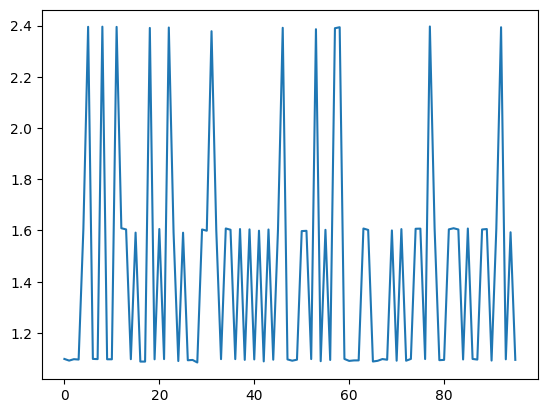

In [75]:
_, p, v = zip(*iterationTrainExamples)
# take chunks of 100 from v 
# v = [(v[i:i+100]) for i in range(0, len(v), 10000)] 
# v = np.concatenate(np.array(v[:-1]))
 
# plt.plot(v)
# p = [(p[i:i+100]) for i in range(0, len(p), 10000)] 
p = np.array(p)
def entropy(p):
    return -np.sum(p * np.log(p + 1e-300), axis=1)
plt.plot(entropy(p)[::1000])

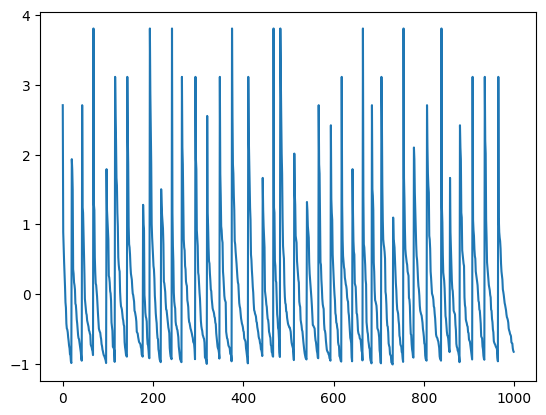